# Time series forecasting 

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['axes.grid'] = False

## Data loading

Load dataset and rename columns to understandable formats

In [2]:
DATA_PATH = "../data/extract.txt"

cols_map = {
    "DTS": "crossTime",
    "LANE": "lane",
    "DIR": "direction",
    "SPD": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
}

columns = list(cols_map.values())

df = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
df.rename(columns=cols_map, inplace=True)

df.head()

,crossTime,lane,direction,speed,nAxles,weight,type
0,20000104T000557,1,1,101,2,17930,11
1,20000104T002824,1,1,83,2,5230,11
2,20000104T003457,1,1,84,2,8310,11
3,20000104T011414,1,1,89,2,7550,11
4,20000104T022526,1,1,104,3,20930,12


Parse crossing time as datetime

In [3]:
df.crossTime = pd.to_datetime(df.crossTime, format="%Y%m%dT%H%M%S")
df.head()

,crossTime,lane,direction,speed,nAxles,weight,type
0,2000-01-04 00:05:57,1,1,101,2,17930,11
1,2000-01-04 00:28:24,1,1,83,2,5230,11
2,2000-01-04 00:34:57,1,1,84,2,8310,11
3,2000-01-04 01:14:14,1,1,89,2,7550,11
4,2000-01-04 02:25:26,1,1,104,3,20930,12


Check to see if there is any invalid data

In [4]:
df.isna().sum()

crossTime    0
lane         0
direction    0
speed        0
nAxles       0
weight       0
type         0
dtype: int64

Convert feature "type" to categorical type

In [5]:
df['type'] = df.type.astype('category')

In [6]:
df

,crossTime,lane,direction,speed,nAxles,weight,type
0,2000-01-04 00:05:57,1,1,101,2,17930,11
1,2000-01-04 00:28:24,1,1,83,2,5230,11
2,2000-01-04 00:34:57,1,1,84,2,8310,11
3,2000-01-04 01:14:14,1,1,89,2,7550,11
4,2000-01-04 02:25:26,1,1,104,3,20930,12
...,...,...,...,...,...,...,...
9994,2000-01-13 05:09:23,1,1,92,4,9960,112
9995,2000-01-13 05:09:57,1,1,91,2,11060,11
9996,2000-01-13 05:14:12,1,1,88,5,14810,122
9997,2000-01-13 05:18:25,1,1,86,3,12340,12


## Initial data explortation

Compute summary statistics

In [7]:
df.describe()

,lane,direction,speed,nAxles,weight
count,9999.0,9999.0,9999.000000,9999.000000,9999.000000
mean,1.0,1.0,88.238024,3.225723,12335.469547
std,0.0,0.0,7.028601,1.111846,6135.098224
min,1.0,1.0,21.000000,2.000000,3500.000000
25%,1.0,1.0,85.000000,2.000000,7630.000000
50%,1.0,1.0,88.000000,3.000000,11440.000000
75%,1.0,1.0,89.000000,4.000000,15630.000000
max,1.0,1.0,184.000000,8.000000,52440.000000


Find the date range of our data

In [8]:
mn, mx = df.crossTime.min(), df.crossTime.max()
print(f"Our data ranges from {mn} to {mx}, ranging a period of {mx - mn}")

Our data ranges from 2000-01-04 00:05:57 to 2000-01-13 05:21:11, ranging a period of 9 days 05:15:14


Explore the other columns of the data

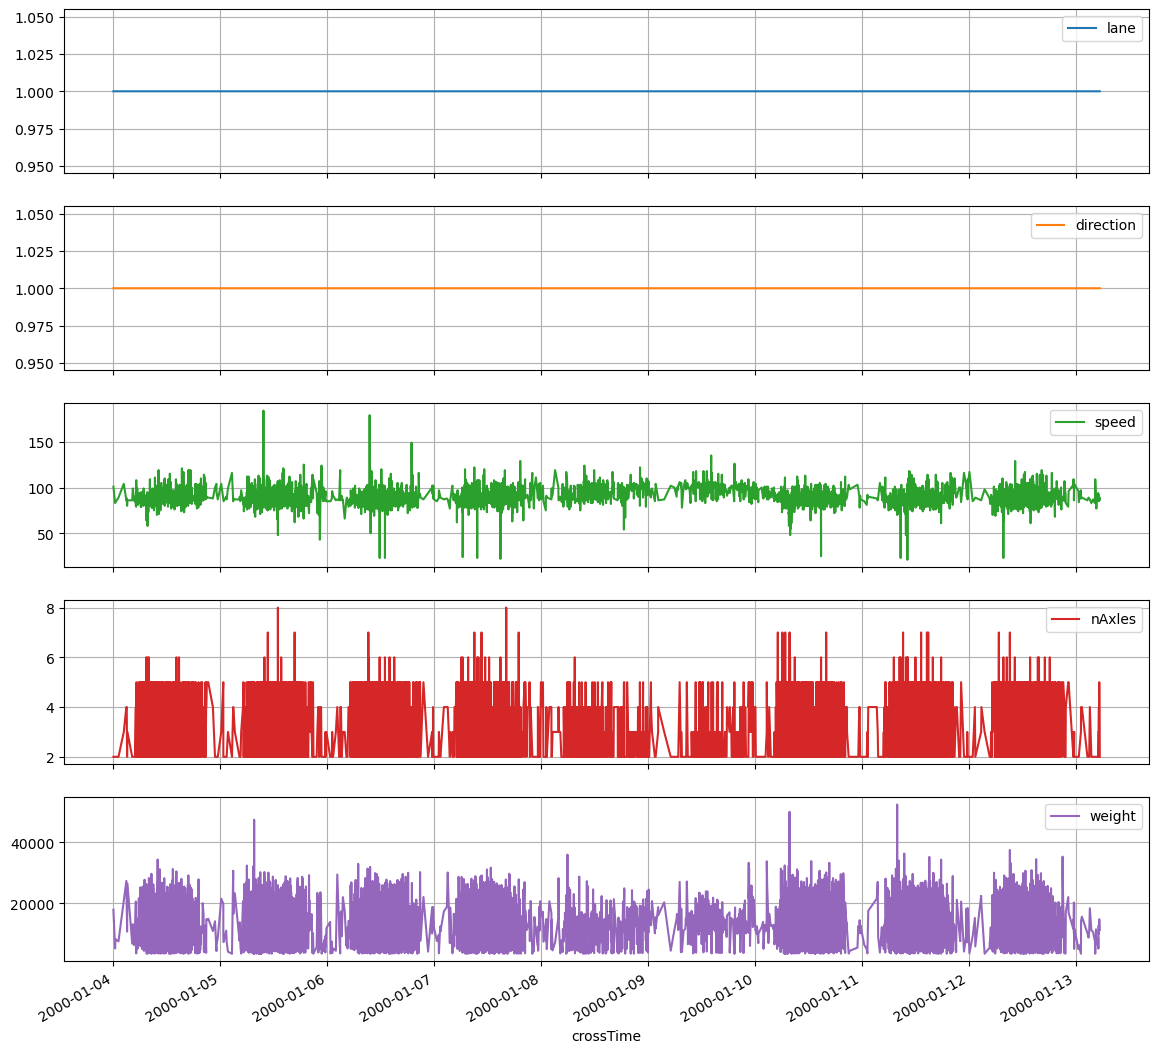

In [9]:
plot_cols = [col for col in columns if col != 'crossTime']

plot_features = df[plot_cols]
plot_features.index = df.crossTime

plot_features.plot(subplots=True, figsize=(14, 14), grid=True)
plt.show()

Downsample the series into 1 hour bins and compute the mean of the values of the timestamps falling into a bin.

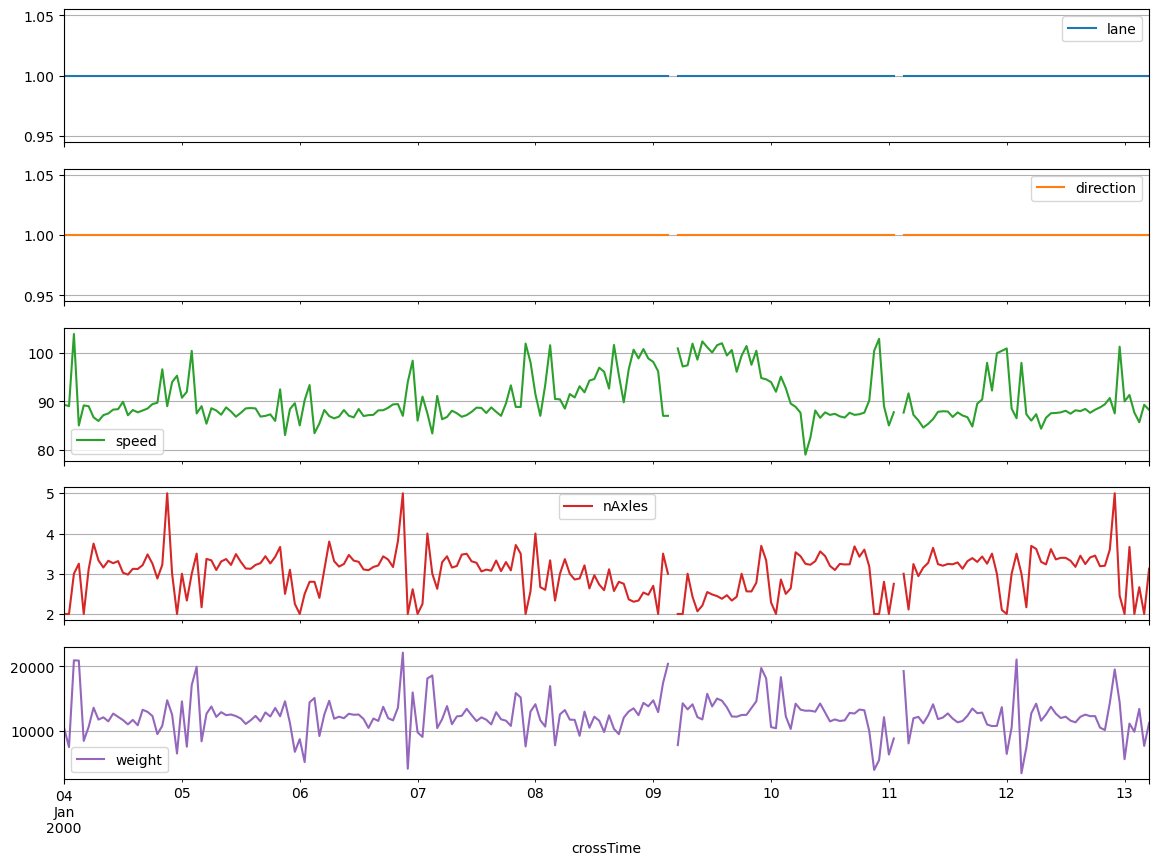

In [10]:
plot_features.resample('1h').mean().plot(subplots=True, grid=True)
plt.show()

Convert categorical variable into dummy variables + plot

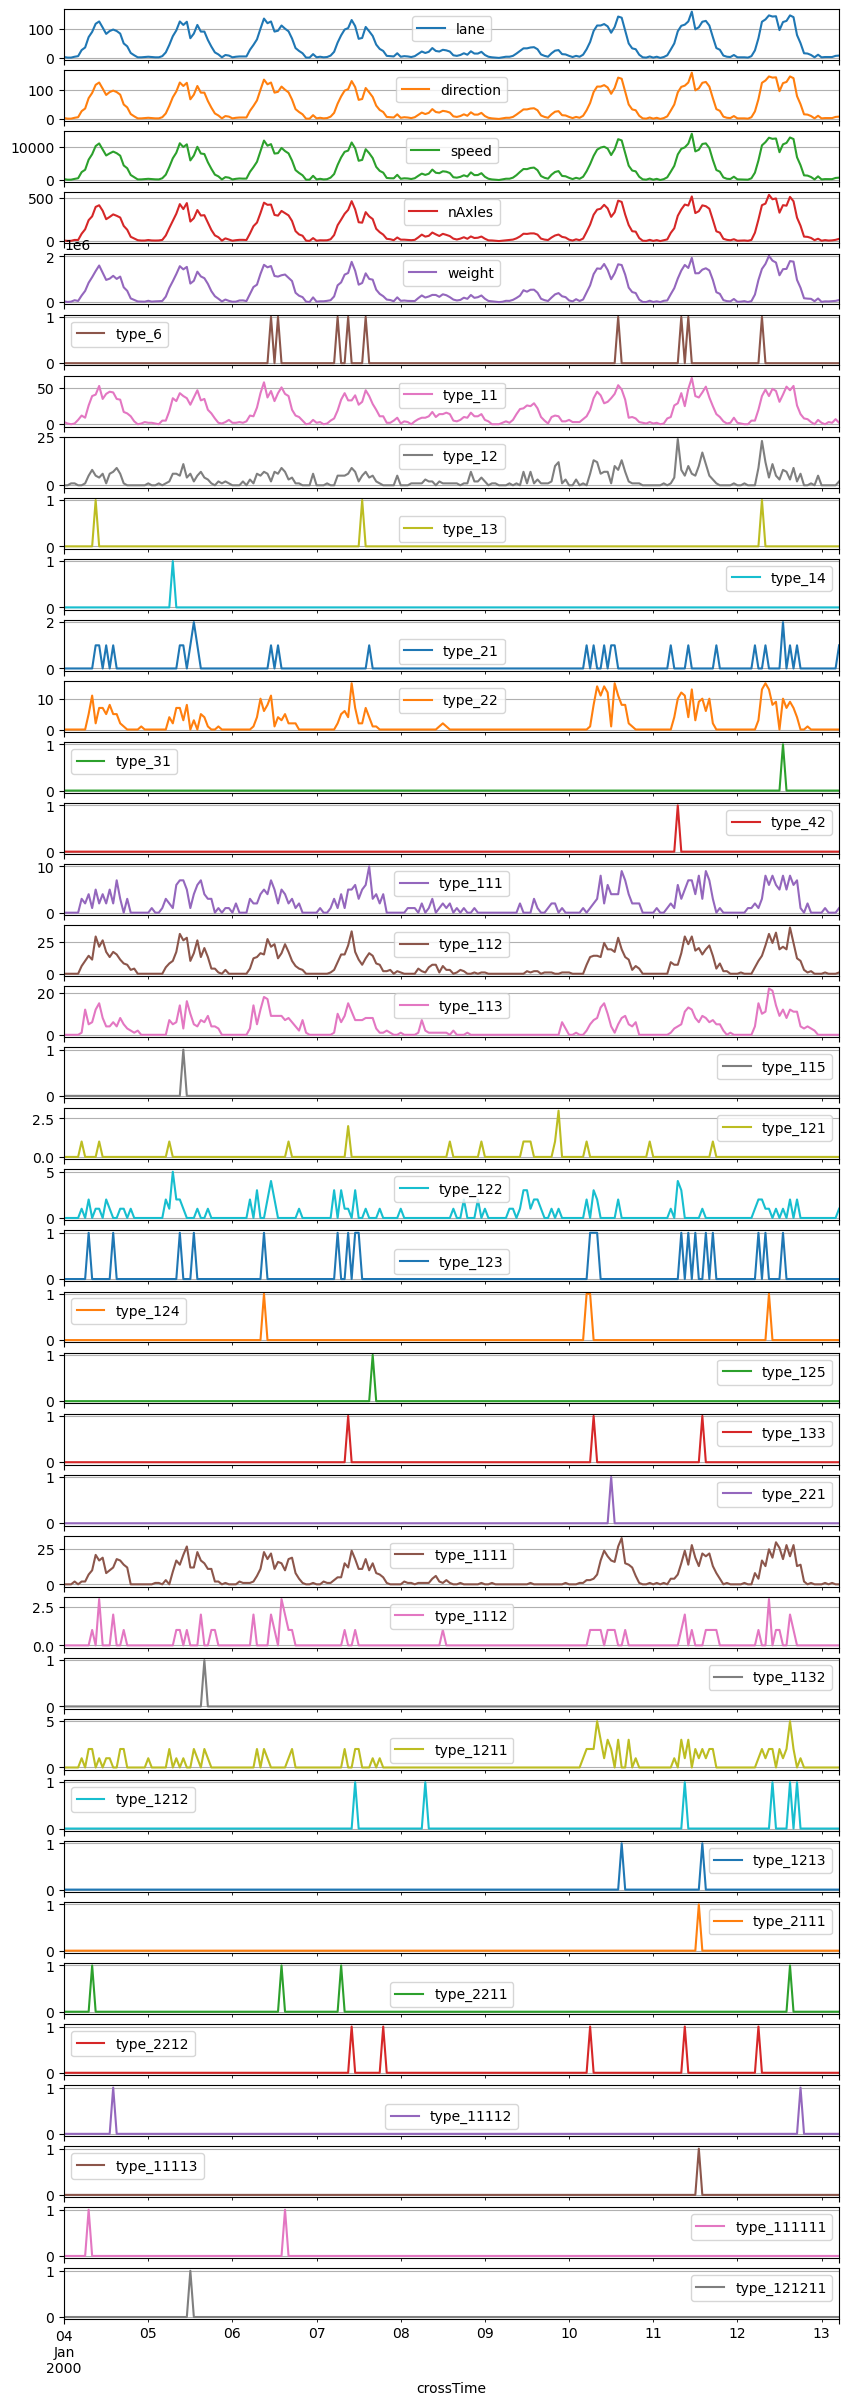

In [11]:
pd.get_dummies(plot_features).resample('1h').sum().plot(subplots=True, figsize=(10, 30), grid=True)
plt.show()

#### Time data exploration

In [12]:
time_column = df['crossTime']
n_rows = len(time_column.index)

time_steps = time_column.diff().astype('timedelta64[s]')[1:]
min_dt, max_dt = time_steps.min(), time_steps.max()
print(f'Minimum dt: {min_dt} \nMaximum dt: {max_dt}')

Minimum dt: 0.0 
Maximum dt: 6921.0


In [13]:
time_steps.plot(kind='hist', bins=100, log=True, figsize=(15,4)).set_xlabel("Time step [s]")

Text(0.5, 0, 'Time step [s]')

In [14]:
time_steps.describe()

count    9998.000000
mean       79.667333
std       257.433715
min         0.000000
25%        10.000000
50%        29.000000
75%        65.000000
max      6921.000000
Name: crossTime, dtype: float64

Power law? Poisson? Investigate this.

## On new dataset

In [310]:
DATA_PATH = "../data/405.txt"

cols_map = {
    "DTS": "crossTime",
    "LANE": "lane",
    "DIR": "direction",
    "SPEED": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
    "Year": "year",
    "Month": "month",
    "Day" : "day",
    "Hour" : "hour",
    "Minute" : "minute",
    "LENTH": "length"
}

columns = list(cols_map.values())

new_df = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
new_df.rename(columns=cols_map, inplace=True)
new_df['crossTime'] = pd.to_datetime(new_df['crossTime'])

new_df.head()

,crossTime,lane,direction,speed,nAxles,weight,length,type,year,month,day,hour,minute
0,2011-04-01 00:41:31.400,2,1,106,2,15980,1361,11,2011,4,1,0,41
1,2011-04-01 00:42:10.500,2,1,116,2,3630,763,11,2011,4,1,0,42
2,2011-04-01 00:47:15.700,2,1,84,4,18480,1556,1111,2011,4,1,0,47
3,2011-04-01 01:23:37.200,2,1,88,2,11050,1000,11,2011,4,1,1,23
4,2011-04-01 01:33:23.400,2,1,89,5,30330,1613,113,2011,4,1,1,33


In [161]:
#Check if there is any na
new_df.isna().sum()

crossTime    0
lane         0
direction    0
speed        0
nAxles       0
weight       0
type         0
year         0
month        0
day          0
hour         0
minute       0
dtype: int64

In [217]:
#convert feature type into category
new_df['type'] = new_df.type.astype('category')

In [218]:
mn, mx = new_df.crossTime.min(), new_df.crossTime.max()
print(f"Our data ranges from {mn} to {mx}, ranging a period of {mx - mn}")

Our data ranges from 2011-04-01 00:41:31.400000 to 2021-03-28 23:29:14.400000, ranging a period of 3649 days 22:47:43


Compute summary statistics

In [164]:
new_df.describe()

,lane,direction,speed,nAxles,weight,year,month,day,hour,minute
count,4.841075e+06,4841075.0,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06
mean,1.635797e+00,1.0,8.586481e+01,3.491157e+00,1.660369e+04,2.016032e+03,6.489607e+00,1.576537e+01,1.183112e+01,2.954497e+01
std,4.812061e-01,0.0,9.172992e+00,1.232331e+00,1.084427e+04,2.988873e+00,3.348895e+00,8.665441e+00,4.092801e+00,1.731409e+01
min,1.000000e+00,1.0,0.000000e+00,2.000000e+00,3.500000e+03,2.011000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.0,8.300000e+01,2.000000e+00,7.720000e+03,2.013000e+03,4.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01
50%,2.000000e+00,1.0,8.700000e+01,4.000000e+00,1.513000e+04,2.016000e+03,6.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01
75%,2.000000e+00,1.0,8.900000e+01,4.000000e+00,2.138000e+04,2.019000e+03,9.000000e+00,2.300000e+01,1.500000e+01,4.500000e+01
max,2.000000e+00,1.0,2.550000e+02,9.000000e+00,9.994000e+04,2.021000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01


From the summary statistics :
- The standard deviation of the direction is 0, meaning we can drop this column.
- The standard deviation of the lane is not exactly 0, meaning we have multiple lanes
- The minimum measured weight is 3500kg.
- We have monster trucks with 9 axles of type 111111111 

In [219]:
new_df.drop('direction', axis=1, inplace=True)
new_df['lane'] = new_df.lane.astype('category')
new_df['lane'].unique()

[2, 1]
Categories (2, int64): [1, 2]

In [197]:
lane_1 = new_df[new_df['lane'].isin([1])]
lane_2 = new_df[new_df['lane'].isin([2])]
nType, nType_1, nType_2 = new_df.type.nunique(), lane_1.type.nunique(), lane_2.type.nunique()
print(f"There are {nType} types in total, {nType_1} on lane 1 and {nType_2} on lane 2")

There are 272 types in total, 193 on lane 1 and 255 on lane 2


In [134]:
#Choosing a specific period of time from the entire dataset.
def choose_date(df, year=None, month=None, day=None, hour=None):
    if year != None:
        df = df[(df.year == year)]
    if month != None:
        df = df[(df.month == month)]
    if day != None:
        df = df[(df.day == day)]
    if hour != None:
        df = df[(df.hour == hour)]
    return df

In [175]:
lane_1_2018_4 = choose_date(lane_1, year = 2018, month = 4)
lane_2_2018_4 = choose_date(lane_2, year = 2018, month = 4)
lane_1_2018_4.index = lane_1_2018_4['crossTime']
lane_2_2018_4.index = lane_2_2018_4['crossTime']

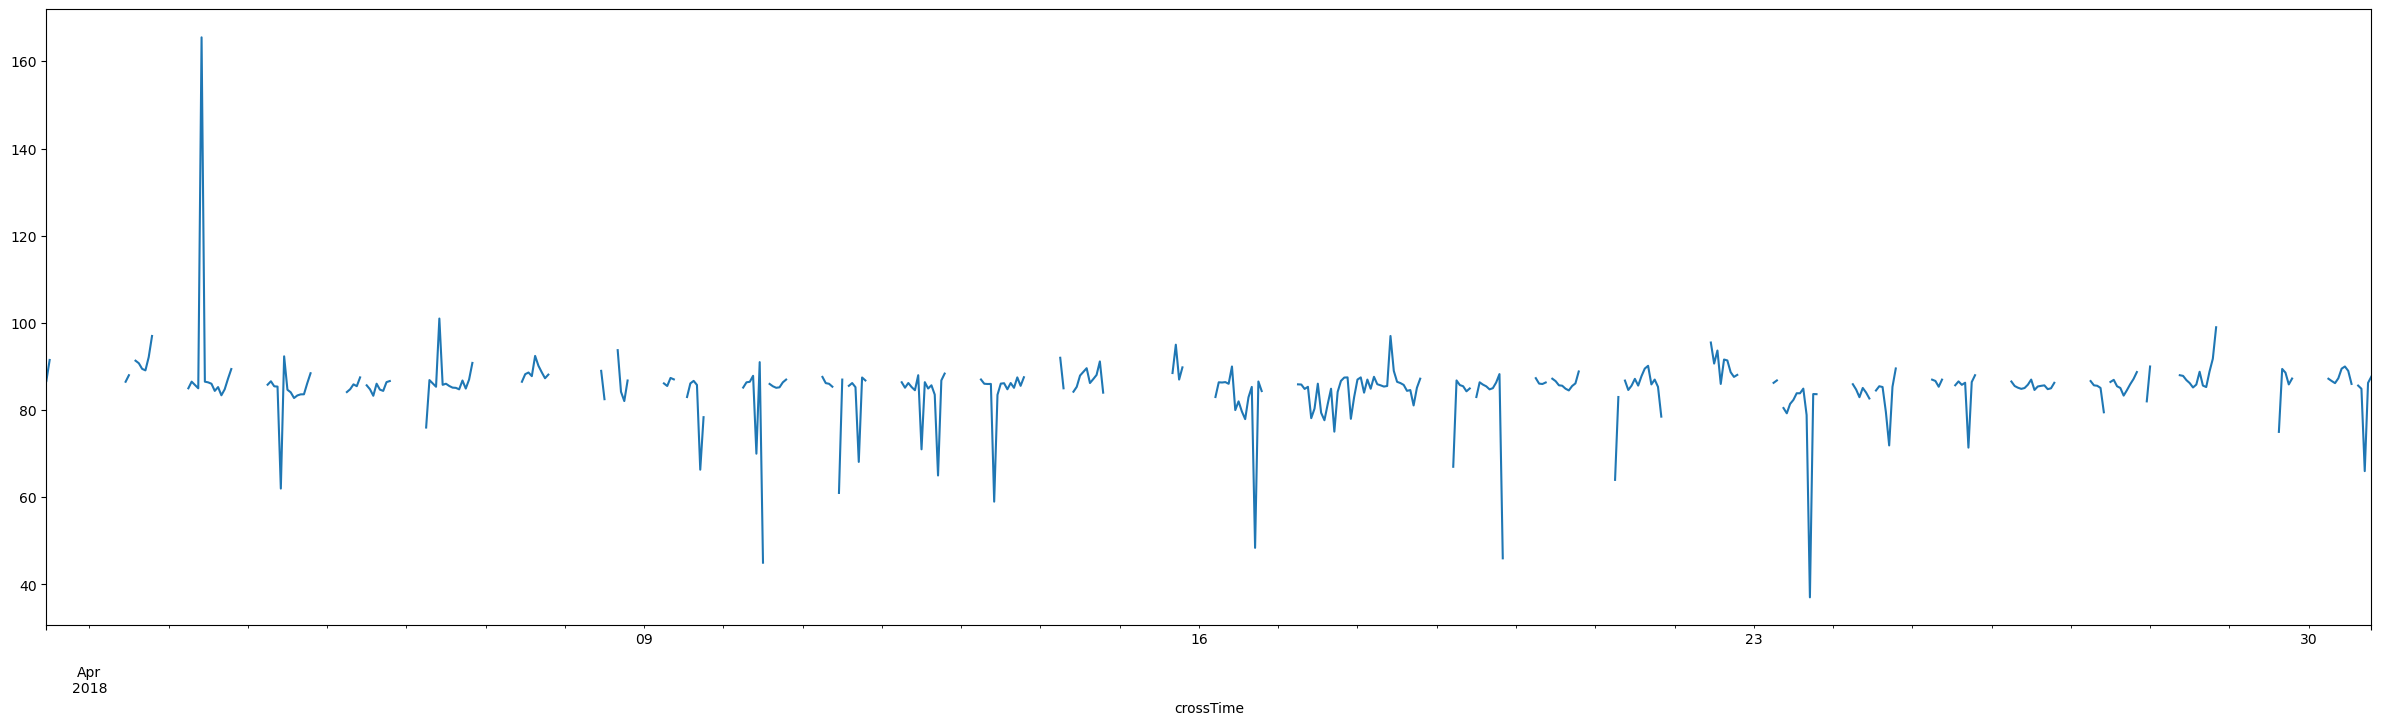

In [200]:
plt.figure(figsize=(30,8))
lane_1_2018_4['speed'].resample('1h').mean().plot()
plt.show()

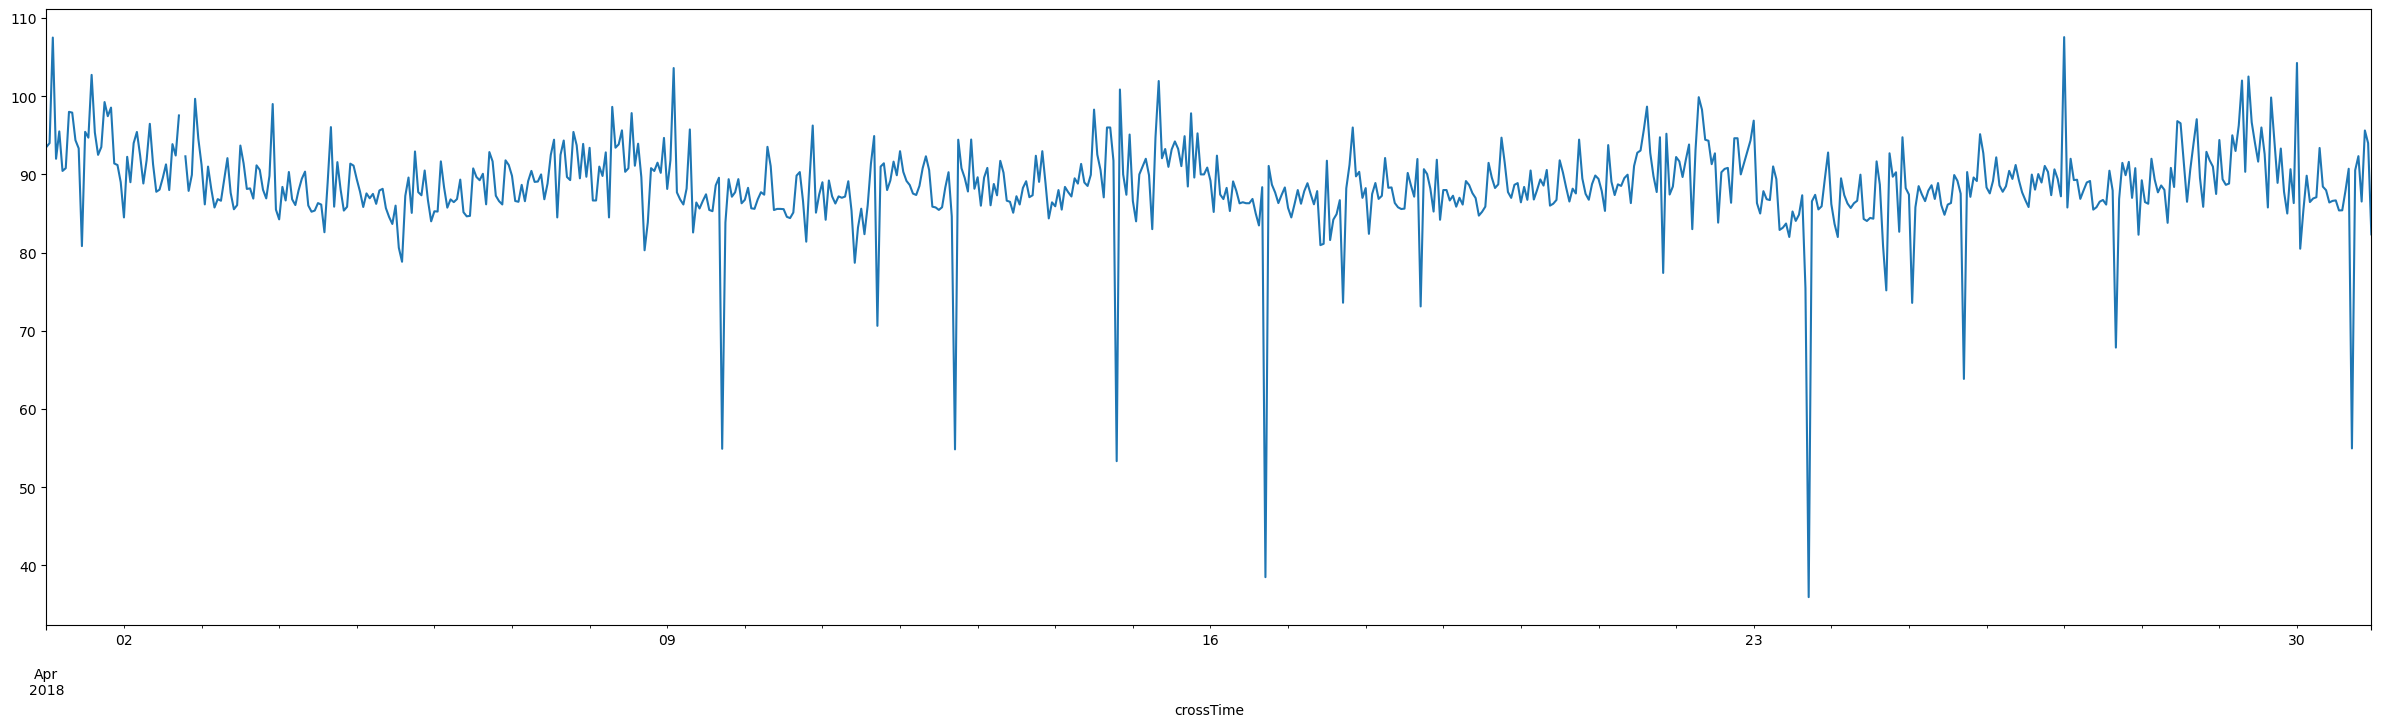

In [201]:
plt.figure(figsize=(30,8))
lane_2_2018_4['speed'].resample('1h').mean().plot()
plt.show()

Usually one drives on the right lane and overtake on the left lane. Here the lane_1 is the left lane and lane_2 is the right one as there are less cars on the lane 1

### Explore speed and weight throughout the year, month, week and day

In [314]:
new_df_2018 = choose_date(new_df, year = 2018)
new_df_2018_4 = choose_date(new_df_2018, month = 4)
new_df_2018_4_10 = choose_date(new_df_2018_4, day = 10)
new_df_2018_4_week = new_df_2018_4.loc[(new_df_2018_4['day'] >= 9) & (new_df_2018_4['day'] <= 15)]

In [257]:
#plot_features = new_df_2018_4.loc[:, ['speed', 'nAxles', 'weight']]

#plot_features.index = new_df_2018_4['crossTime']
#plot_features.resample('1h').mean().plot(subplots=True, grid=True)
#plt.show()

We can see that the number of axles and the weight are highly correlated, so we decide to drop the nAxles feature.

In [228]:
new_df.drop('nAxles', axis=1, inplace=True)
new_df_2018_4.drop('nAxles', axis=1, inplace=True)

yaaaaaay colors

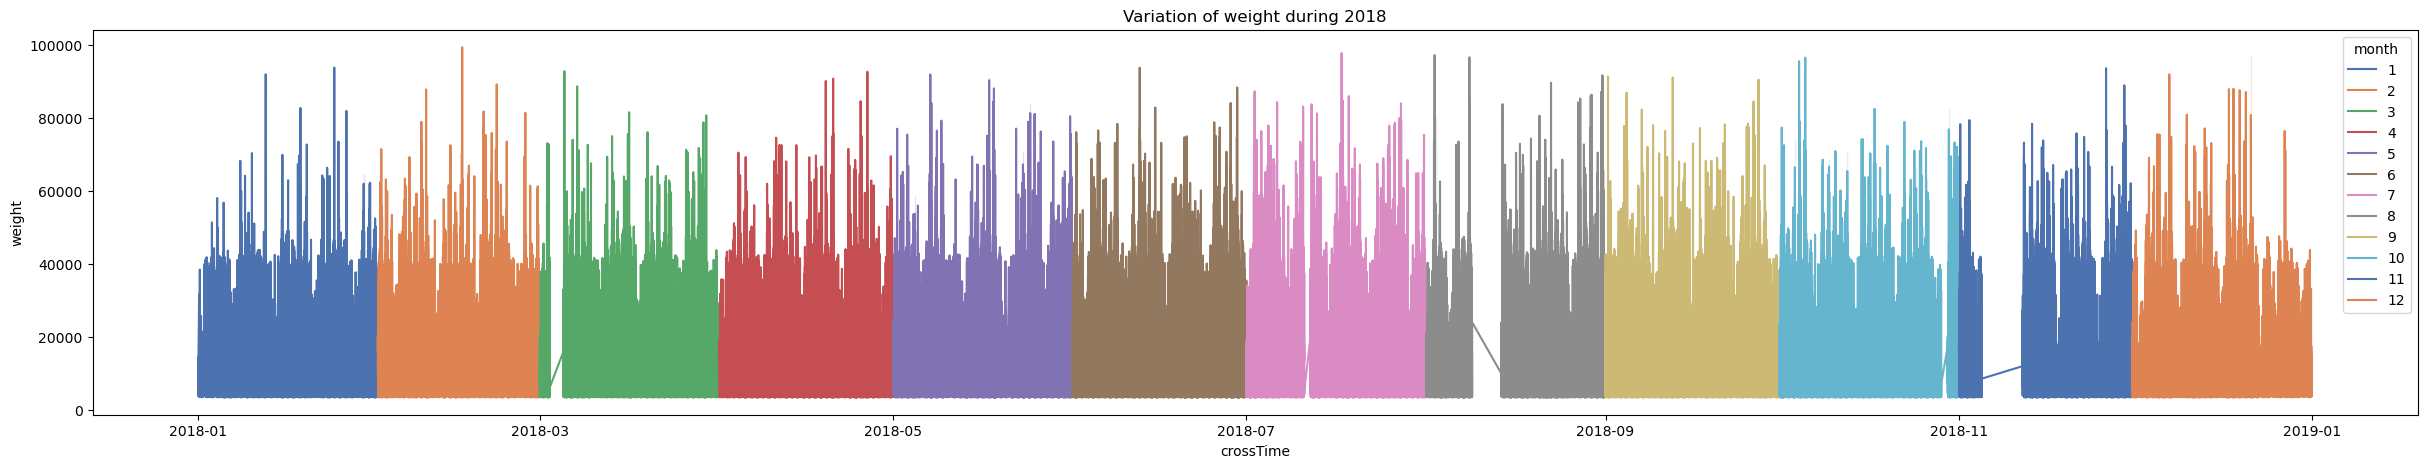

In [258]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during 2018')
sns.lineplot(x = new_df_2018.crossTime, y= new_df_2018.weight, hue=new_df_2018.month, palette="deep");
plt.show()

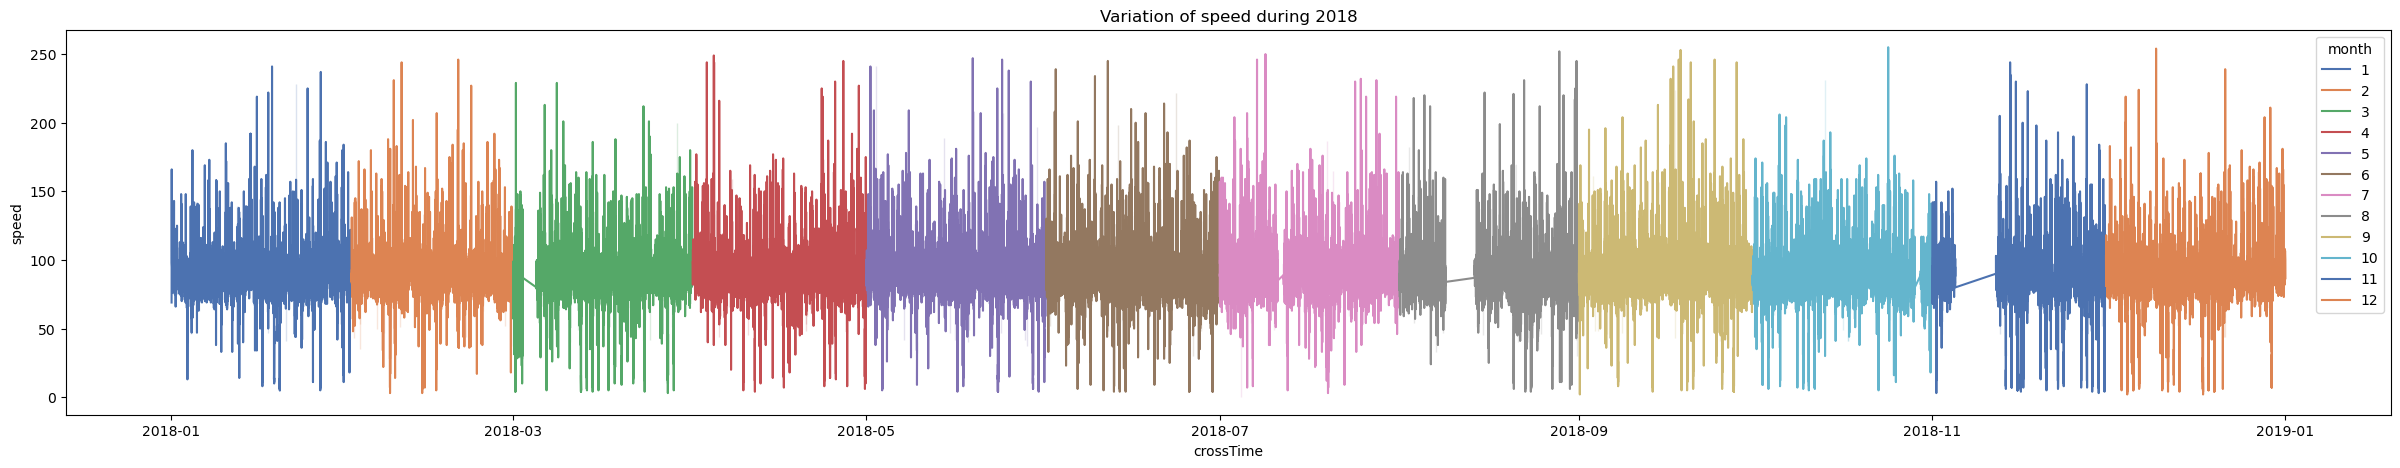

In [260]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 2018')
sns.lineplot(x = new_df_2018.crossTime, y= new_df_2018.speed, hue=new_df_2018.month, palette="deep");
plt.show()

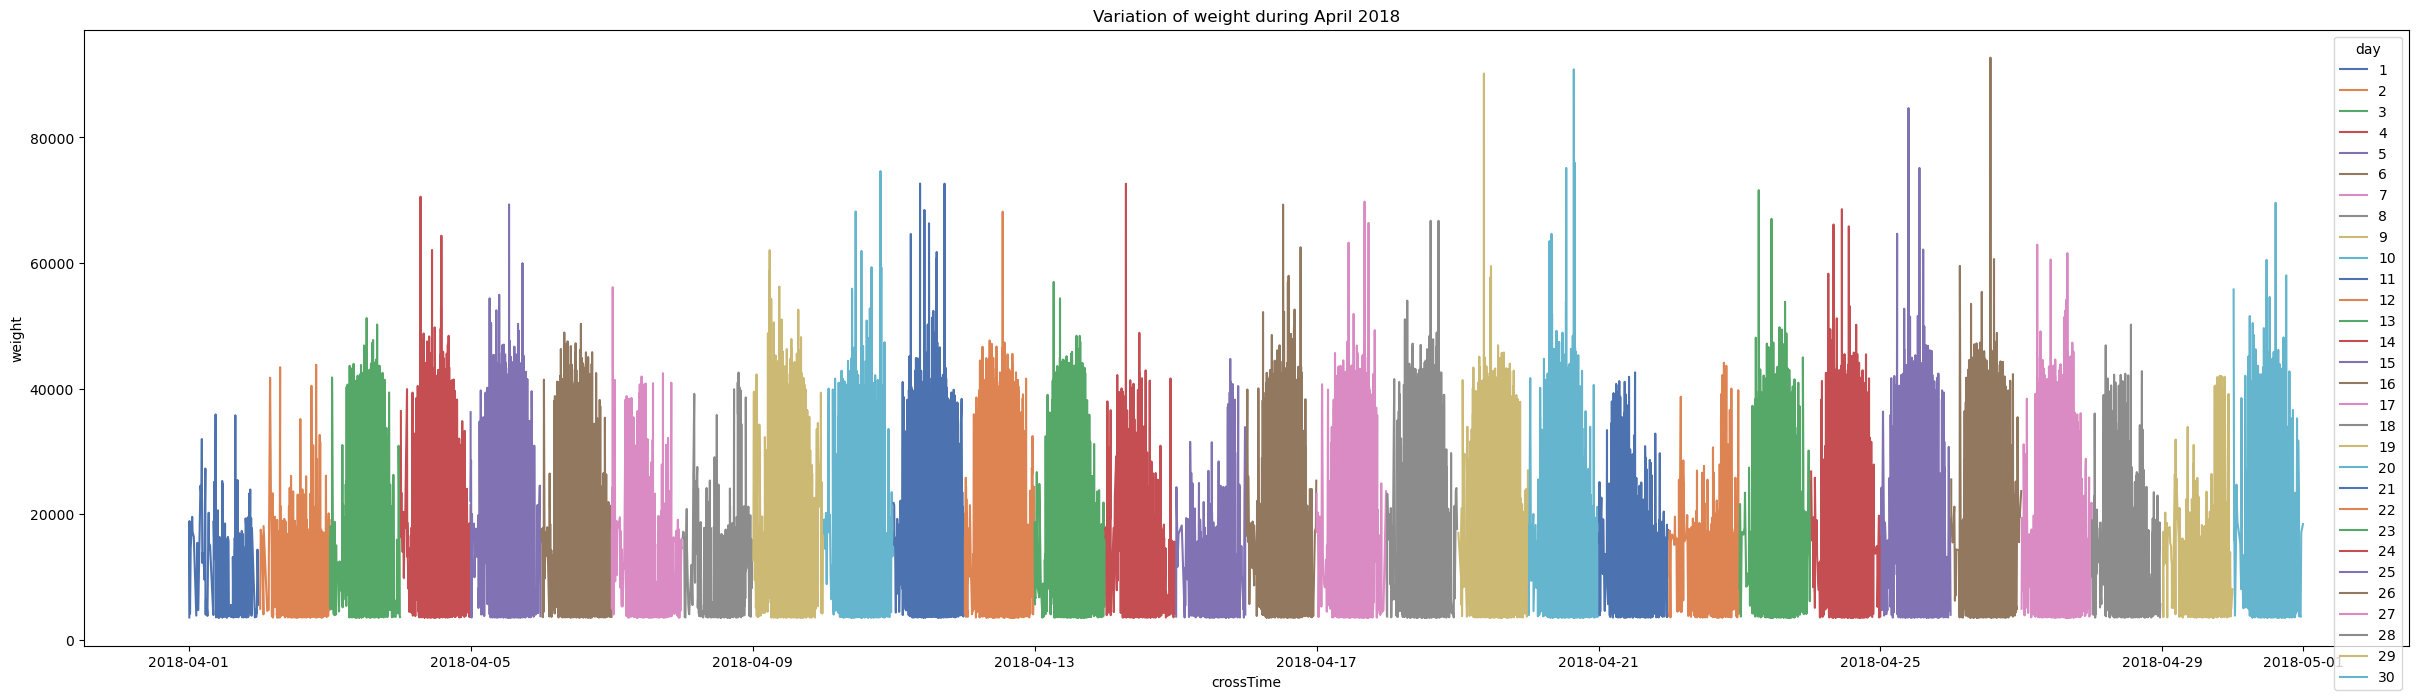

In [253]:
plt.figure(figsize=(30,8))
plt.title('Variation of weight during April 2018')
sns.lineplot(x = new_df_2018_4.crossTime, y= new_df_2018_4.weight, hue=new_df_2018_4.day, palette="deep");
plt.show()

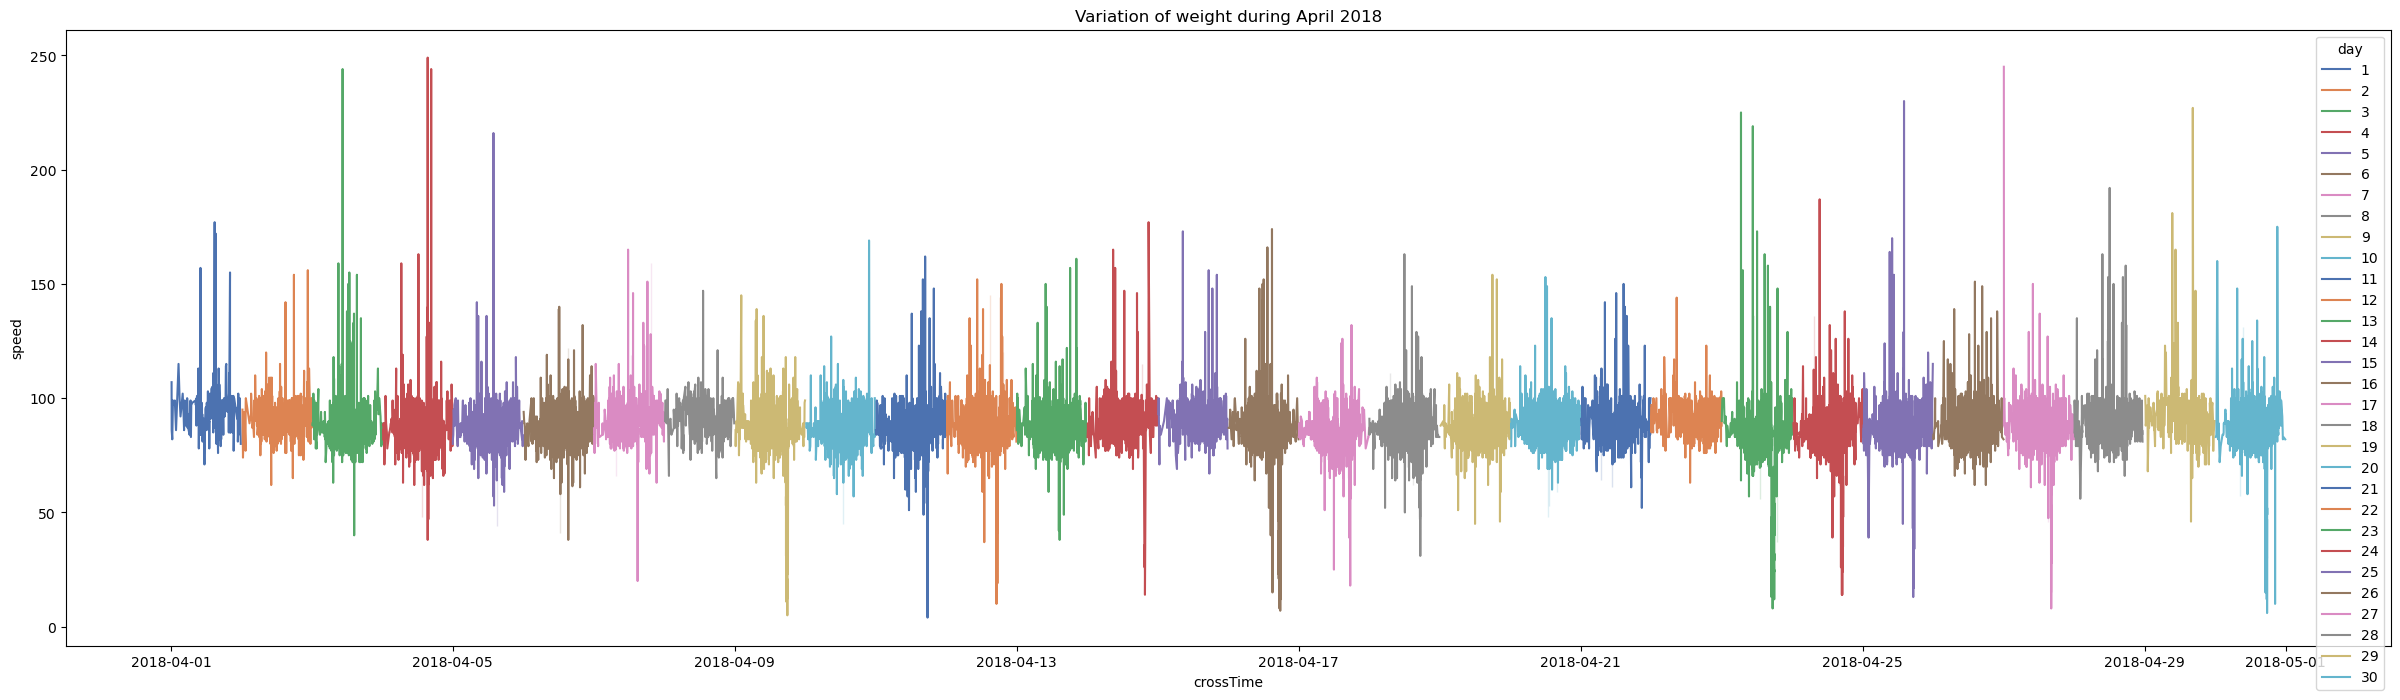

In [252]:
plt.figure(figsize=(30,8))
plt.title('Variation of speed during April 2018')
sns.lineplot(x = new_df_2018_4.crossTime, y= new_df_2018_4.speed, hue=new_df_2018_4.day, palette="deep");
plt.show()

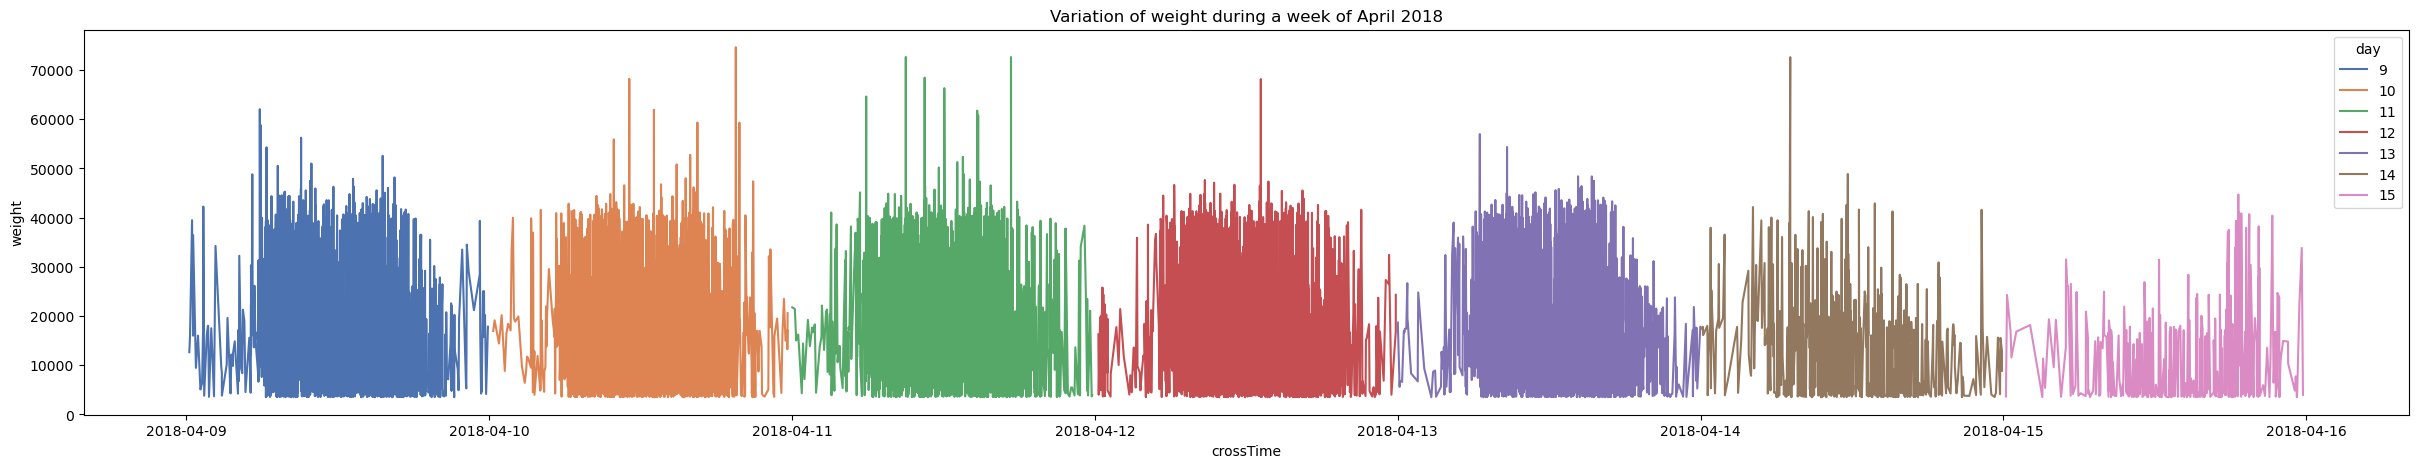

In [248]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during a week of April 2018')
sns.lineplot(x = new_df_2018_4_week.crossTime, y= new_df_2018_4_week.weight, hue=new_df_2018_4_week.day, palette="deep");
plt.show()

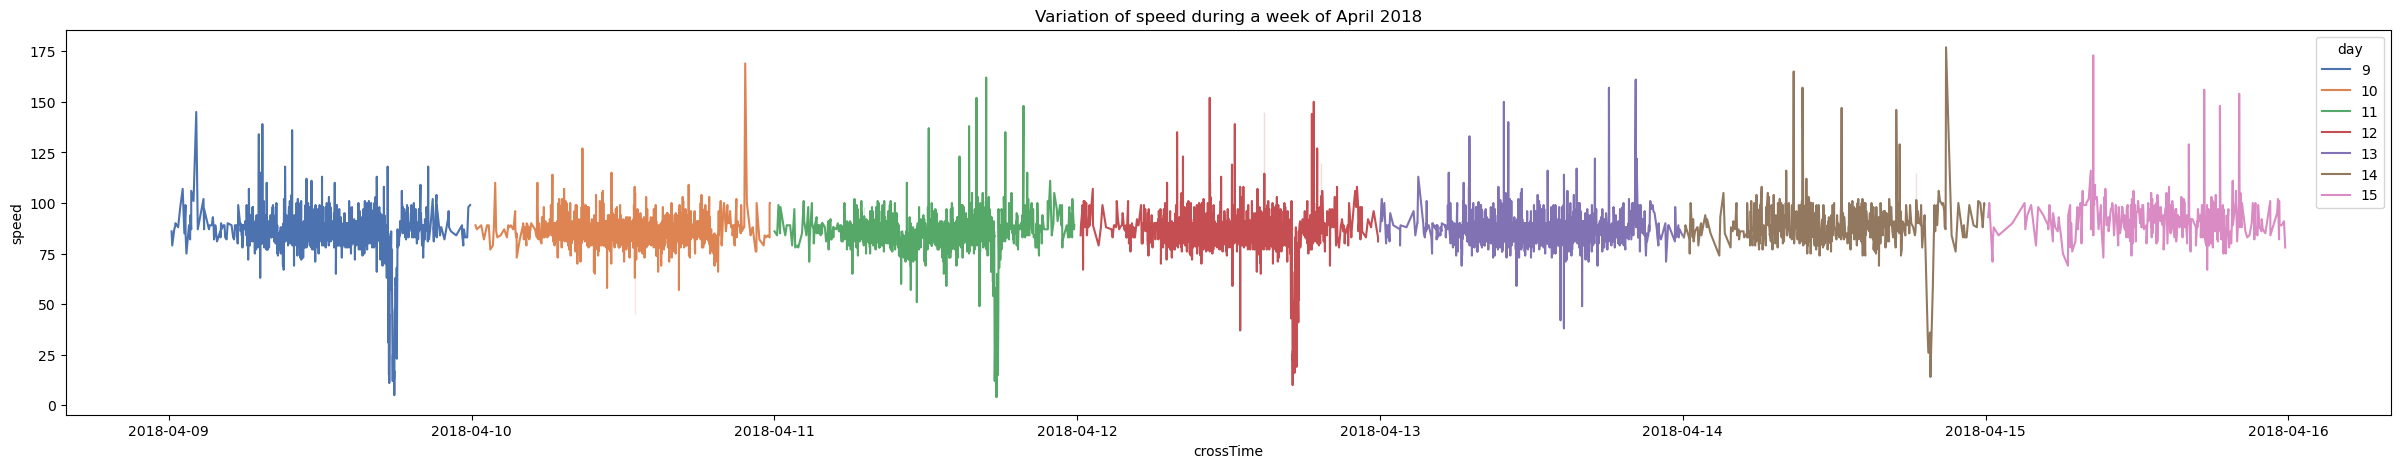

In [249]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during a week of April 2018')
sns.lineplot(x = new_df_2018_4_week.crossTime, y= new_df_2018_4_week.speed, hue=new_df_2018_4_week.day, palette="deep");
plt.show()

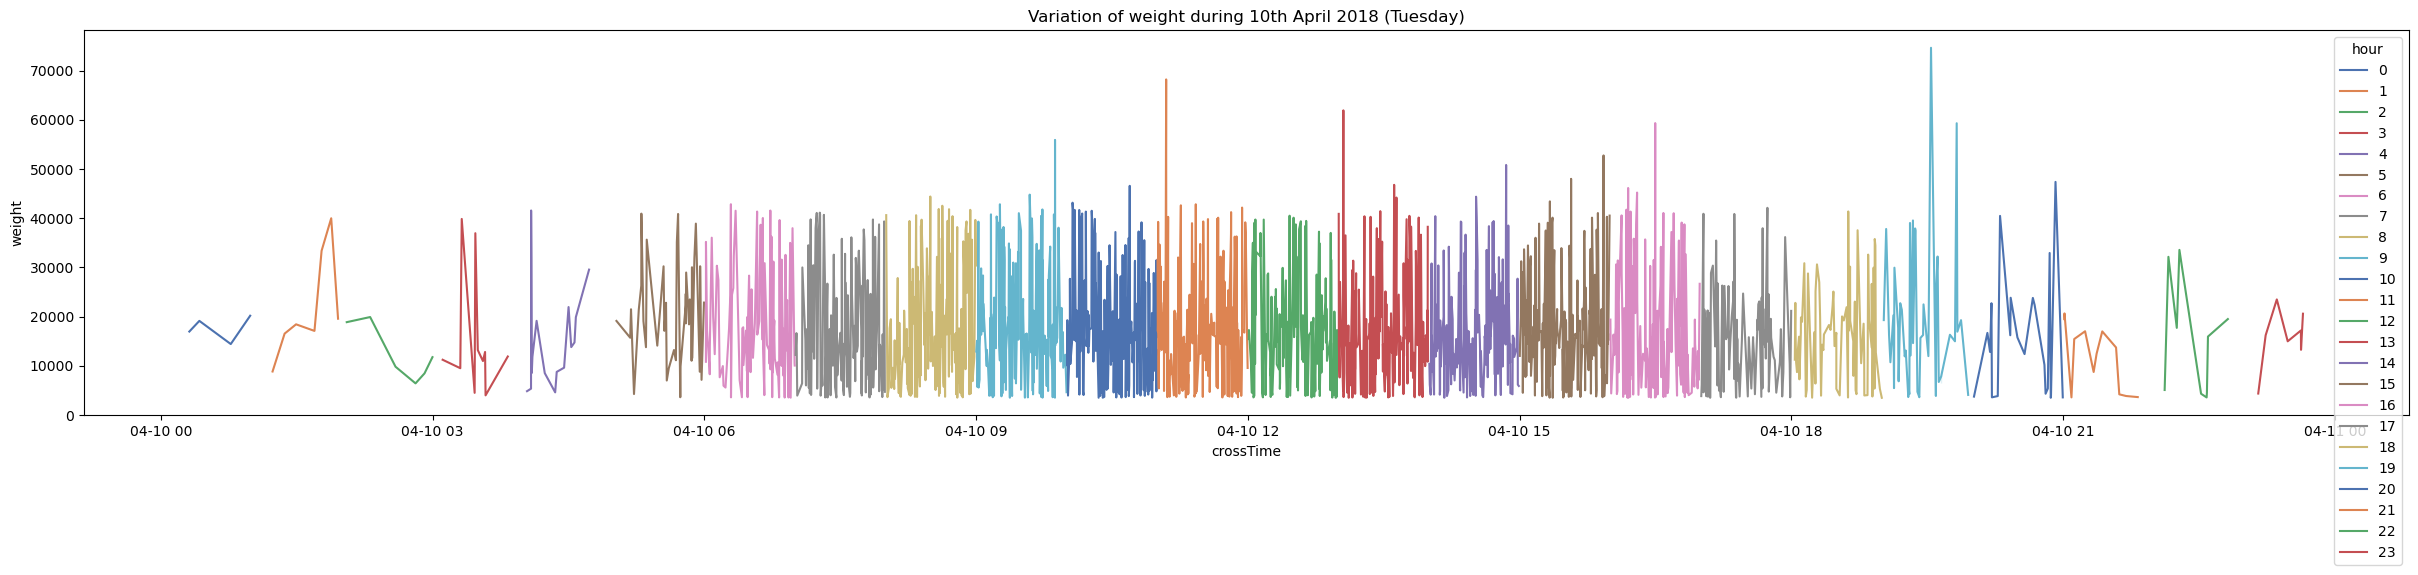

In [265]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during 10th April 2018 (Tuesday)')
sns.lineplot(x = new_df_2018_4_10.crossTime, y= new_df_2018_4_10.weight, hue=new_df_2018_4_10.hour, palette="deep");
plt.show()

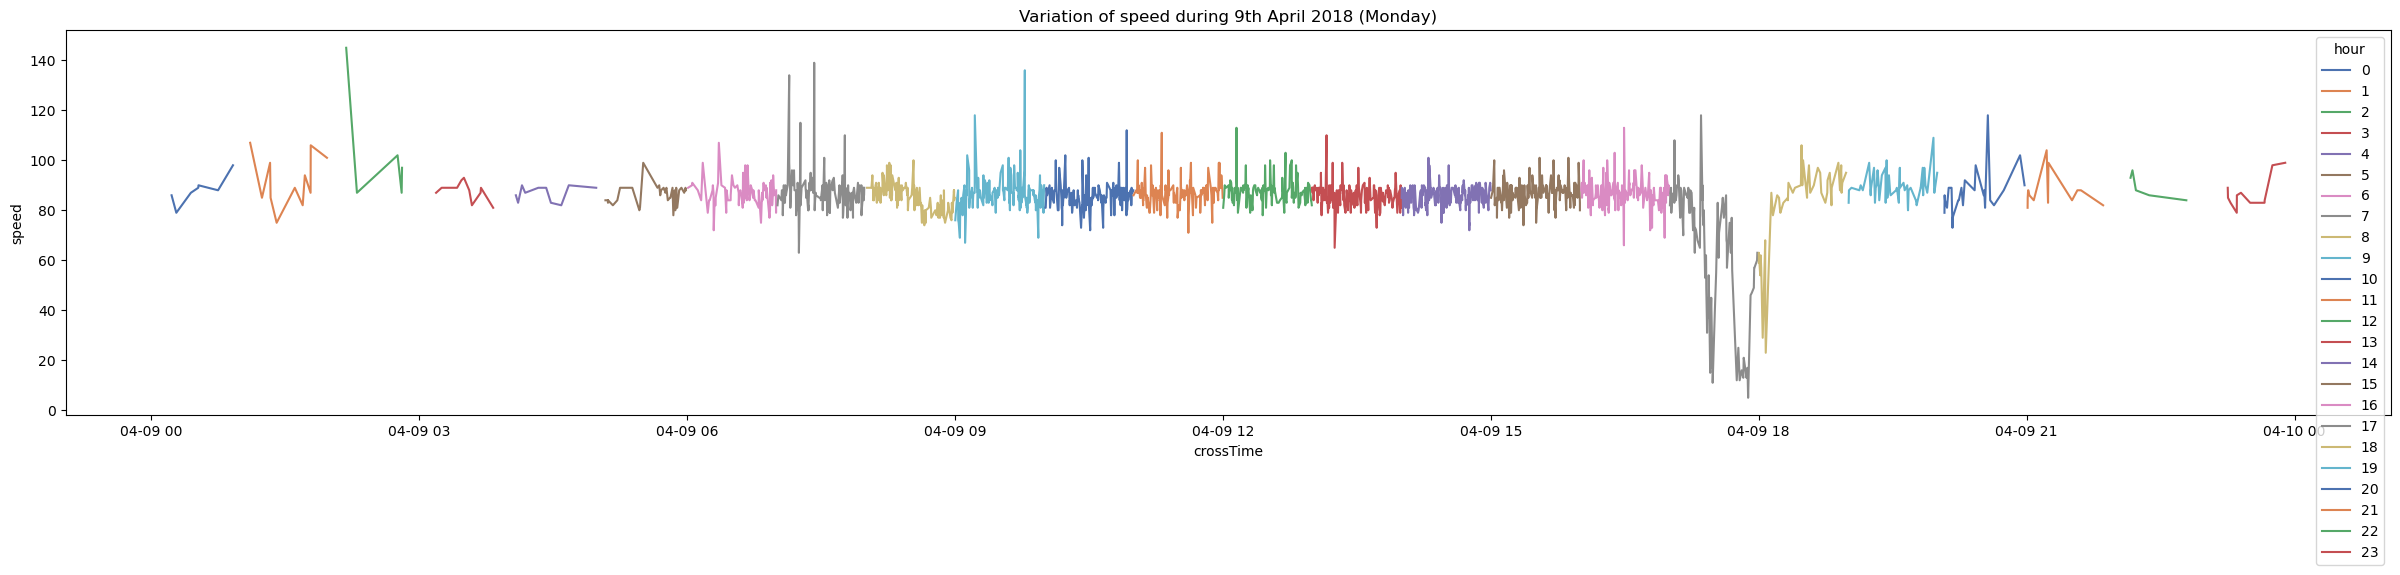

In [328]:
new_df_2018_4_9 = choose_date(new_df_2018_4, day = 9)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 9th April 2018 (Monday)')
sns.lineplot(x = new_df_2018_4_9.crossTime, y= new_df_2018_4_9.speed, hue=new_df_2018_4_9.hour, palette="deep");
plt.show()

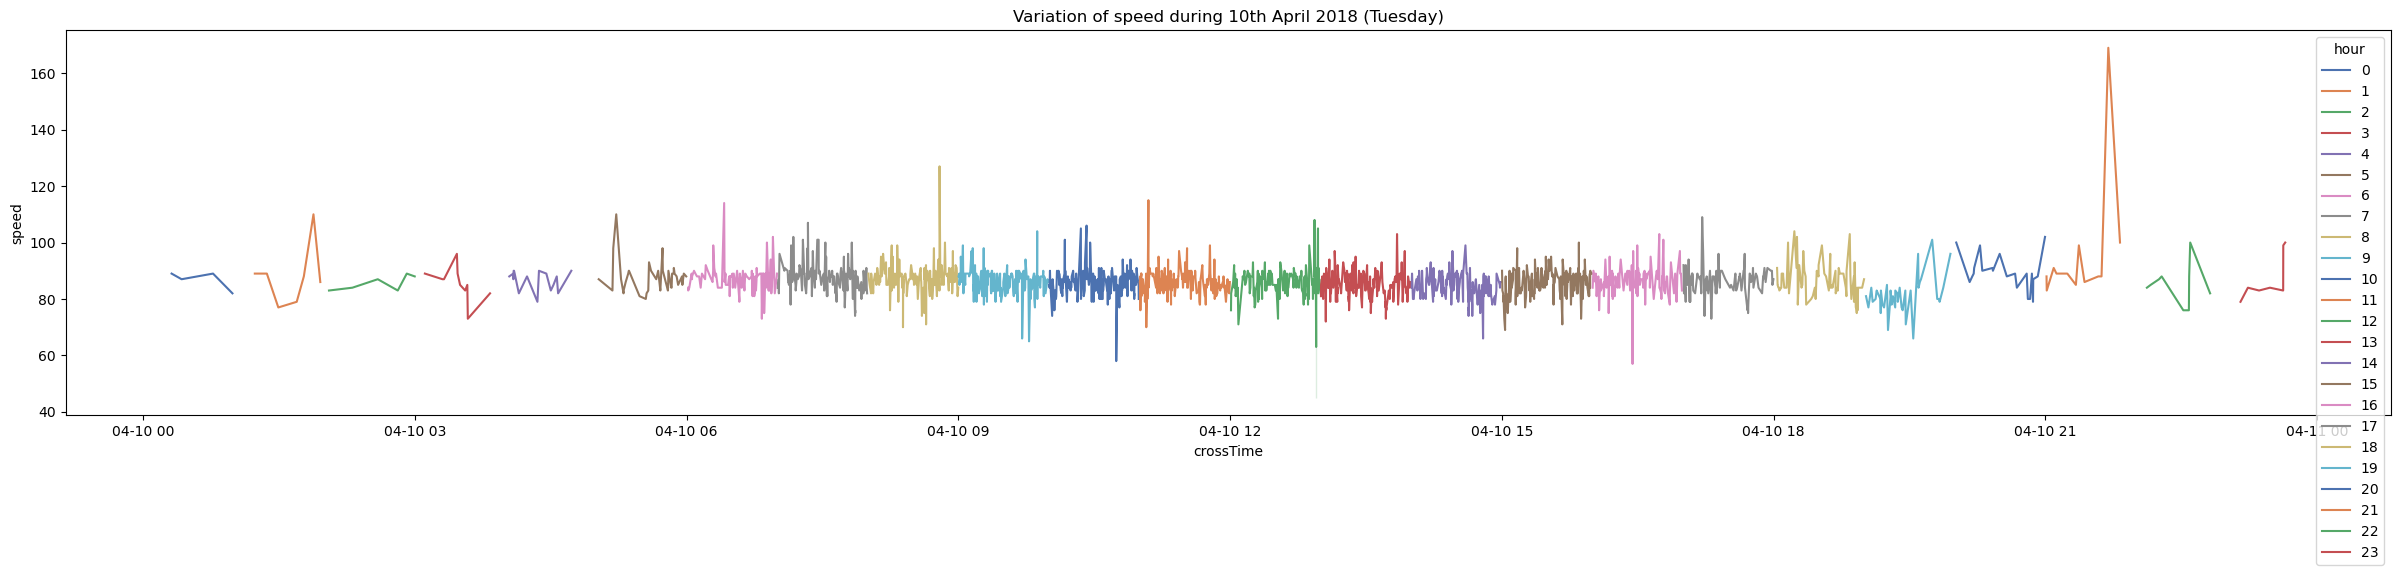

In [246]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 10th April 2018 (Tuesday)')
sns.lineplot(x = new_df_2018_4_10.crossTime, y= new_df_2018_4_10.speed, hue=new_df_2018_4_10.hour, palette="deep");
plt.show()

In [ ]:
#### Check speed variation throughout

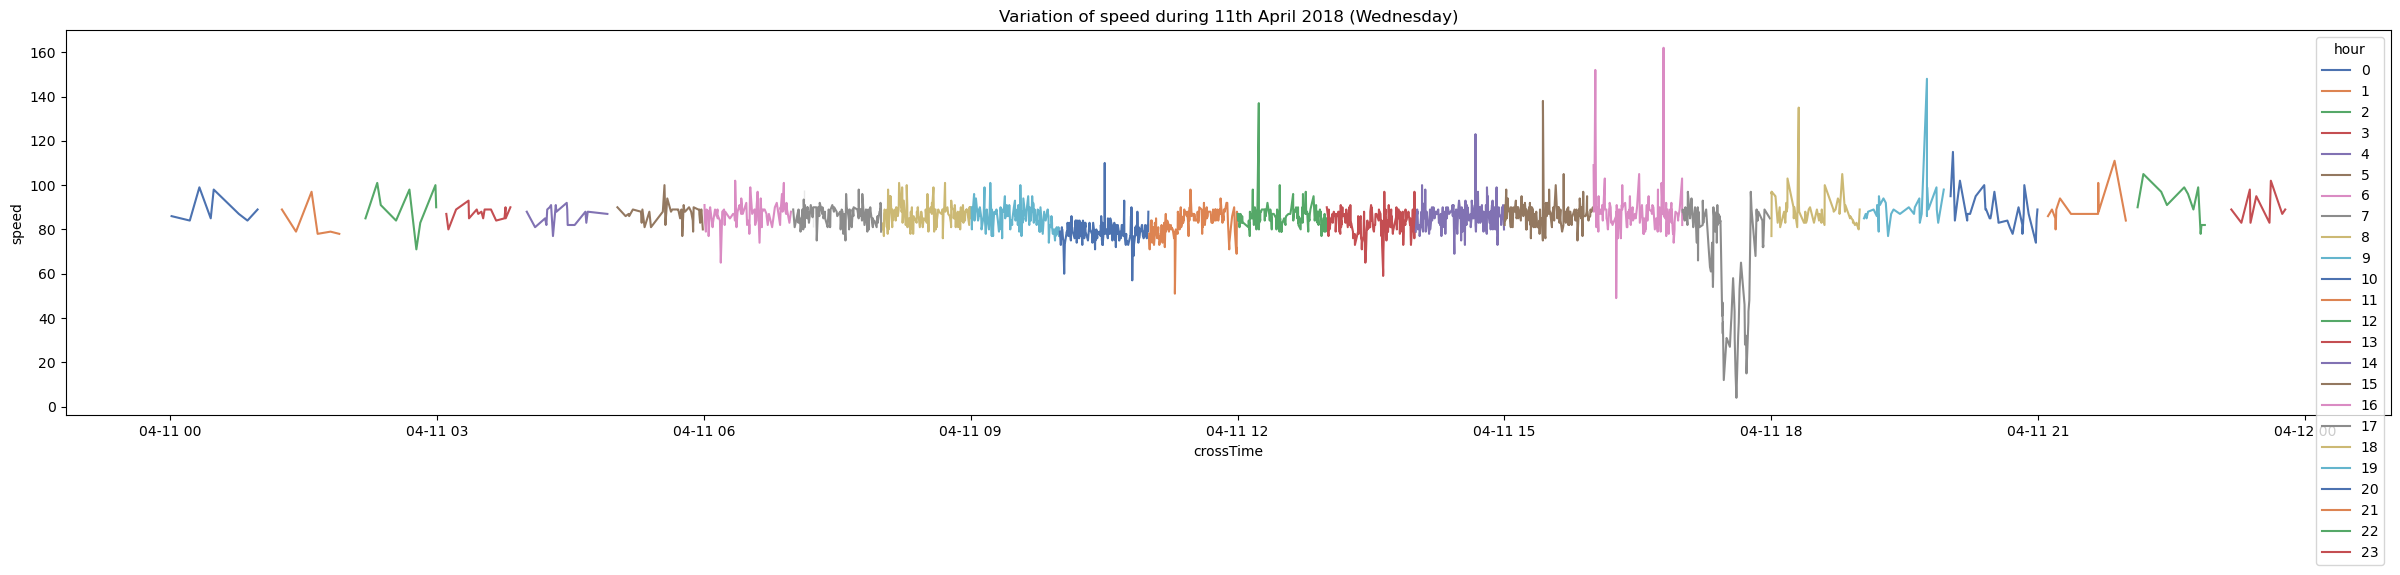

In [316]:
new_df_2018_4_11 = choose_date(new_df_2018_4, day = 11)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 11th April 2018 (Wednesday)')
sns.lineplot(x = new_df_2018_4_11.crossTime, y= new_df_2018_4_11.speed, hue=new_df_2018_4_11.hour, palette="deep");
plt.show()

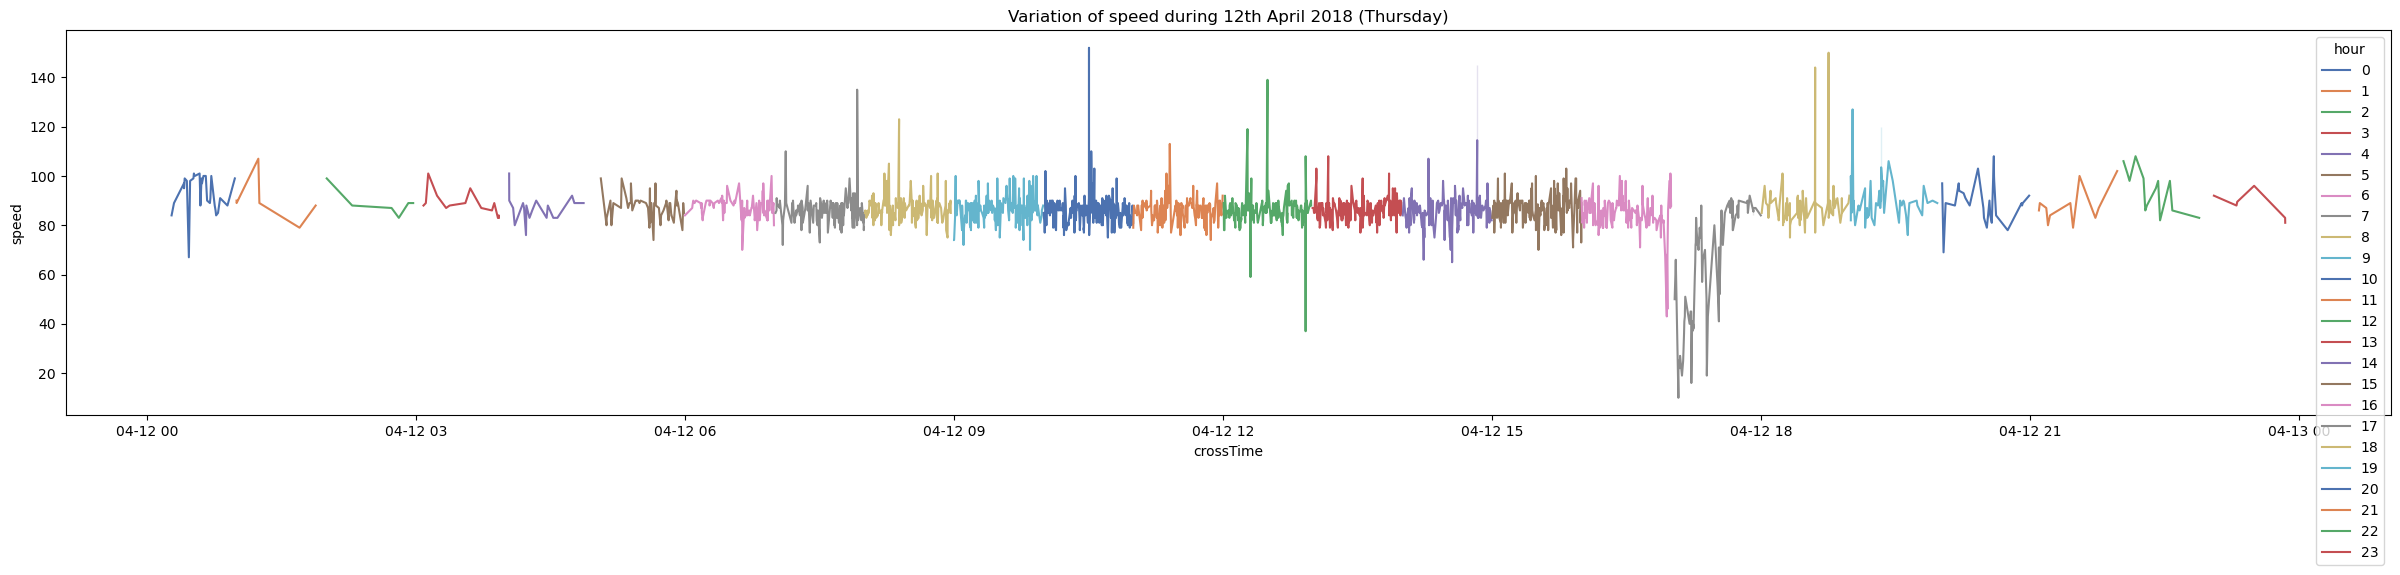

In [318]:
new_df_2018_4_12 = choose_date(new_df_2018_4, day = 12)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 12th April 2018 (Thursday)')
sns.lineplot(x = new_df_2018_4_12.crossTime, y= new_df_2018_4_12.speed, hue=new_df_2018_4_12.hour, palette="deep");
plt.show()

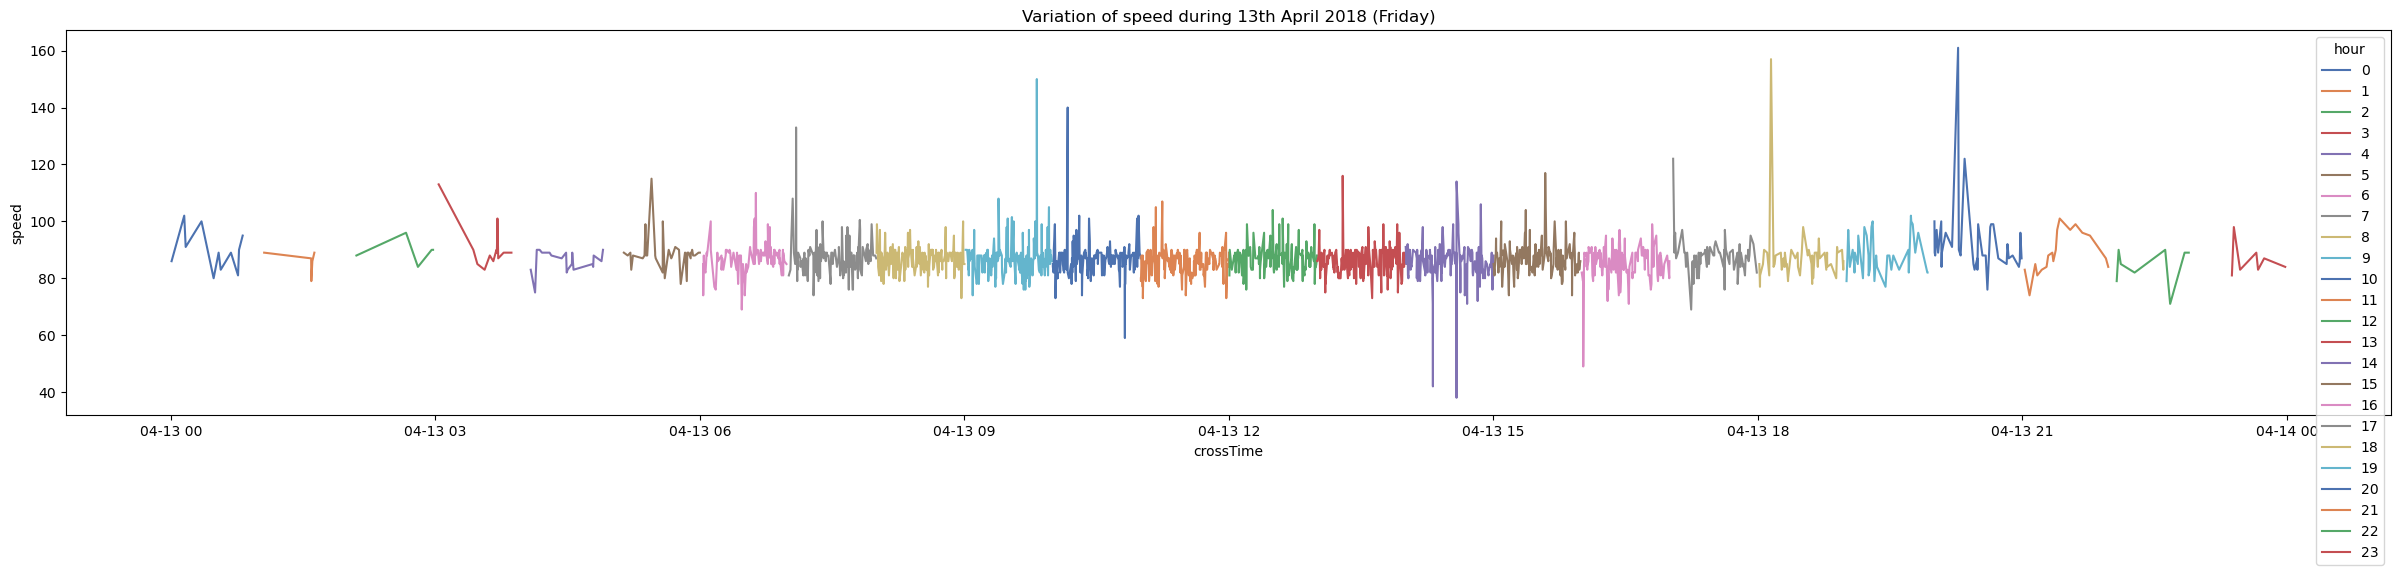

In [334]:
new_df_2018_4_13 = choose_date(new_df_2018_4, day = 13)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 13th April 2018 (Friday)')
sns.lineplot(x = new_df_2018_4_13.crossTime, y= new_df_2018_4_13.speed, hue=new_df_2018_4_13.hour, palette="deep");
plt.show()

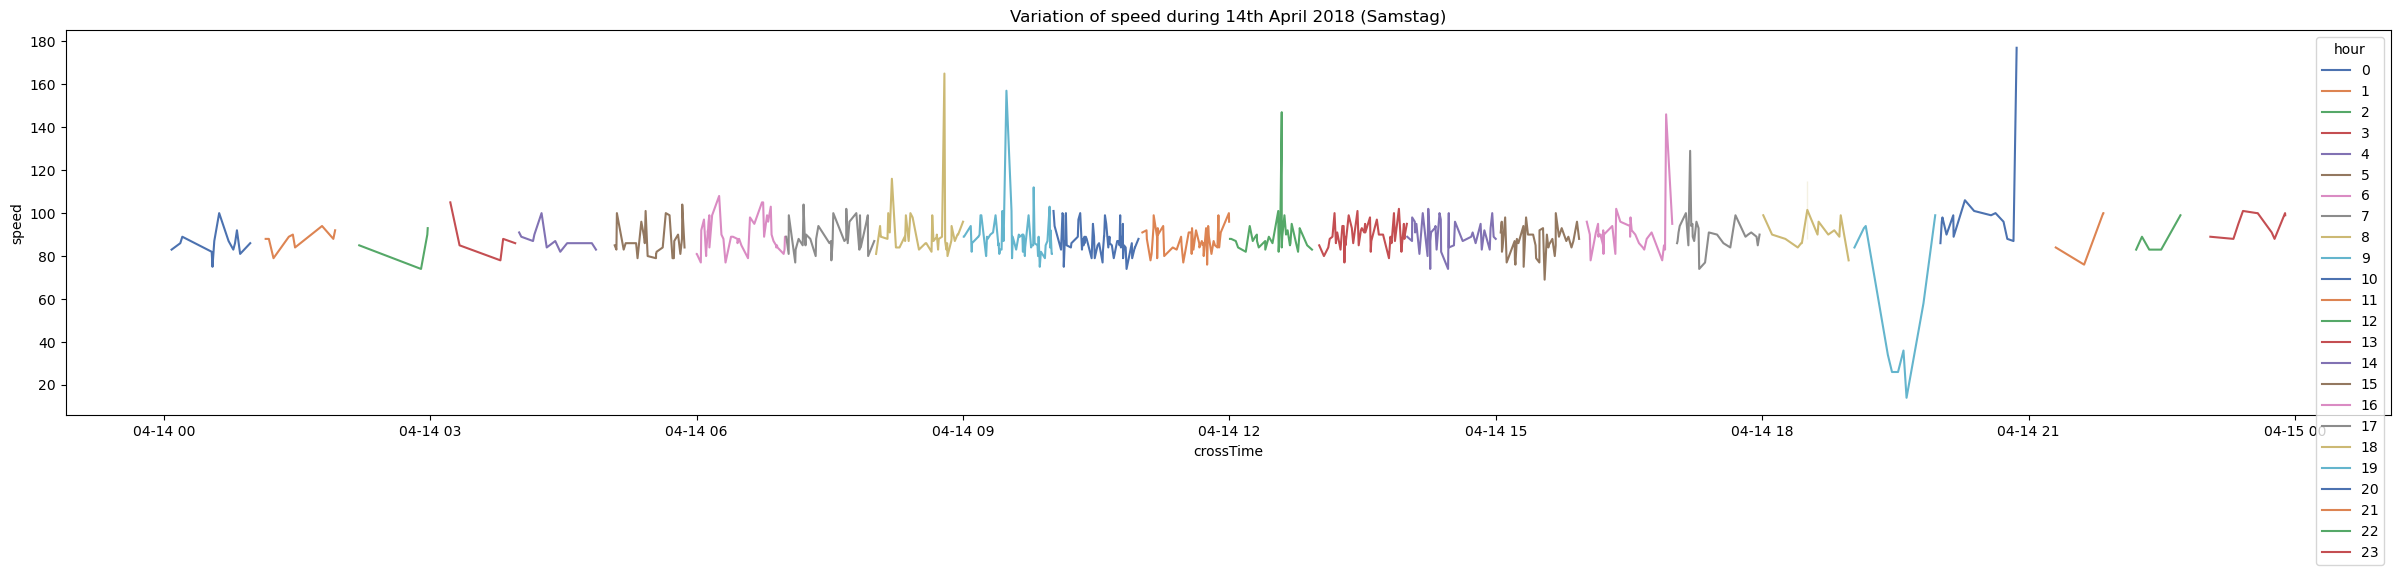

In [333]:
new_df_2018_4_14 = choose_date(new_df_2018_4, day = 14)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 14th April 2018 (Samstag)')
sns.lineplot(x = new_df_2018_4_14.crossTime, y= new_df_2018_4_14.speed, hue=new_df_2018_4_14.hour, palette="deep");
plt.show()

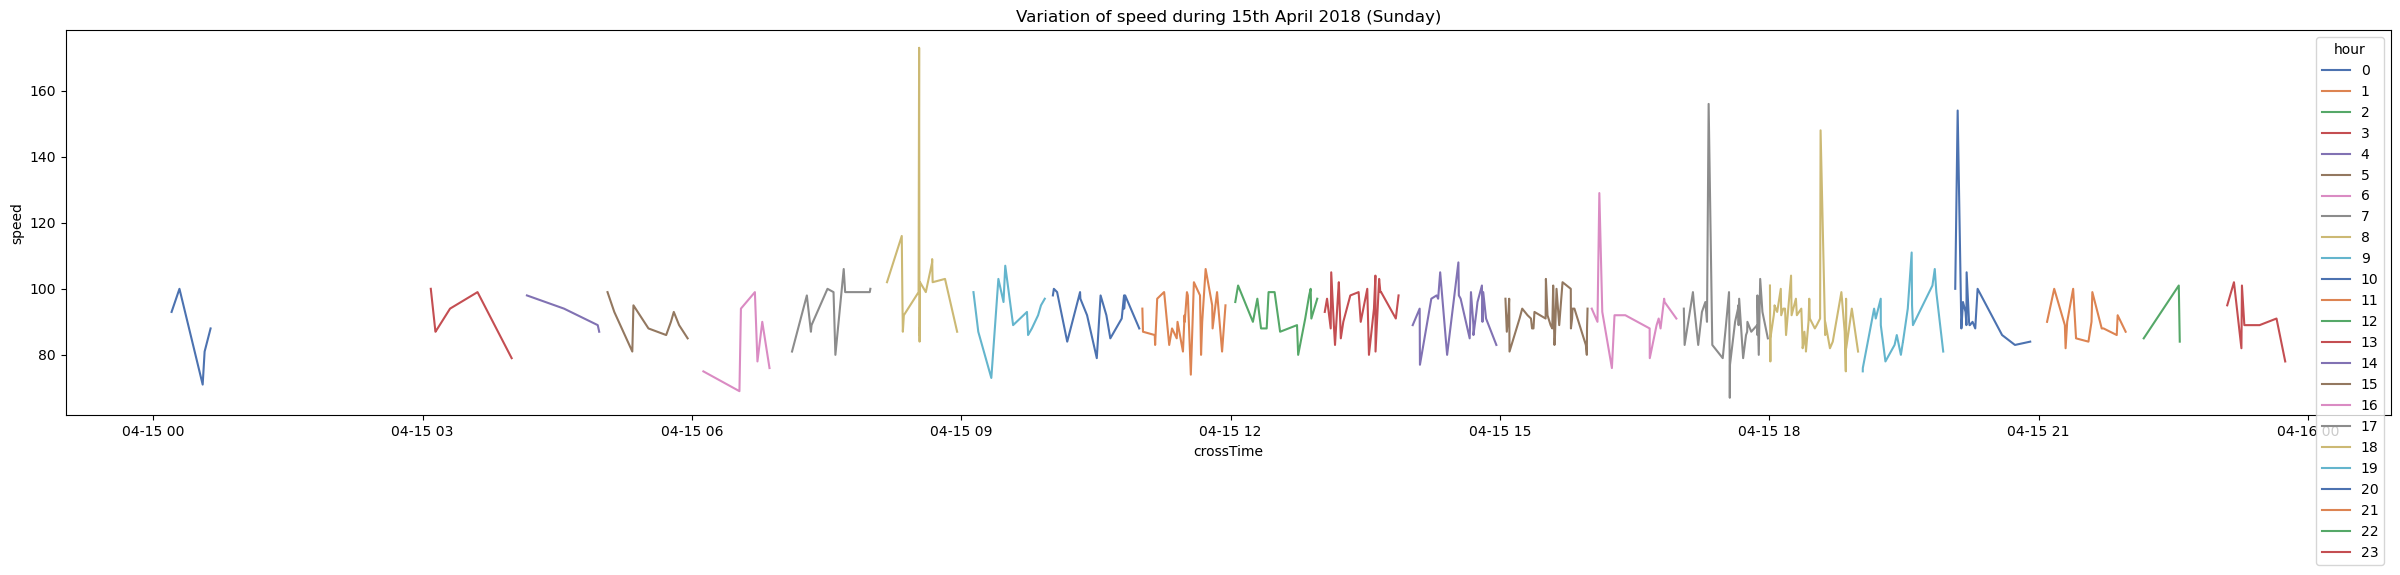

In [332]:
new_df_2018_4_15 = choose_date(new_df_2018_4, day = 15)
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 15th April 2018 (Sunday)')
sns.lineplot(x = new_df_2018_4_15.crossTime, y= new_df_2018_4_15.speed, hue=new_df_2018_4_15.hour, palette="deep");
plt.show()

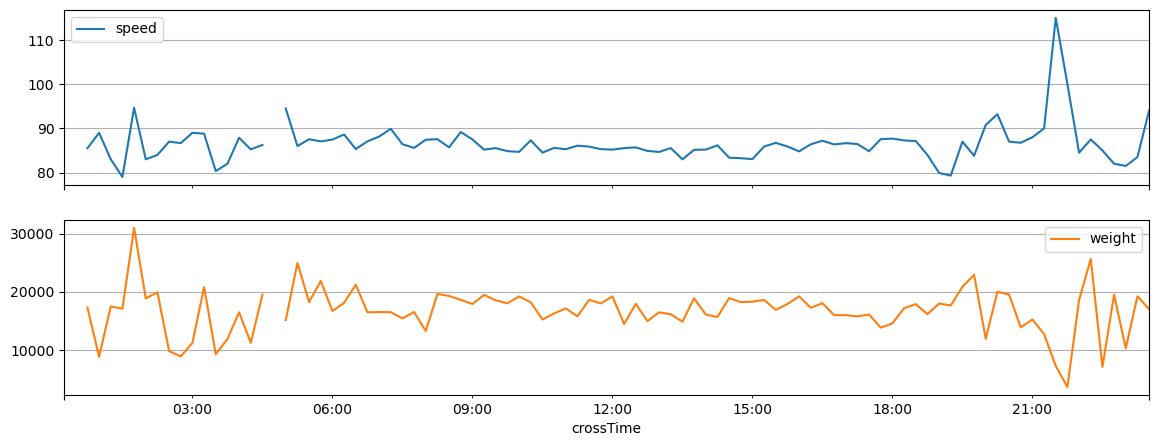

In [267]:
plot_features = new_df_2018_4_10.loc[:, ['speed', 'weight']]

plot_features.index = new_df_2018_4_10['crossTime']
plot_features.resample('15T').mean().plot(subplots=True, grid=True, figsize=(14, 5))
plt.show()

It seems like that it is quite constant from 6am to 6pm

### Speed and weight distribution

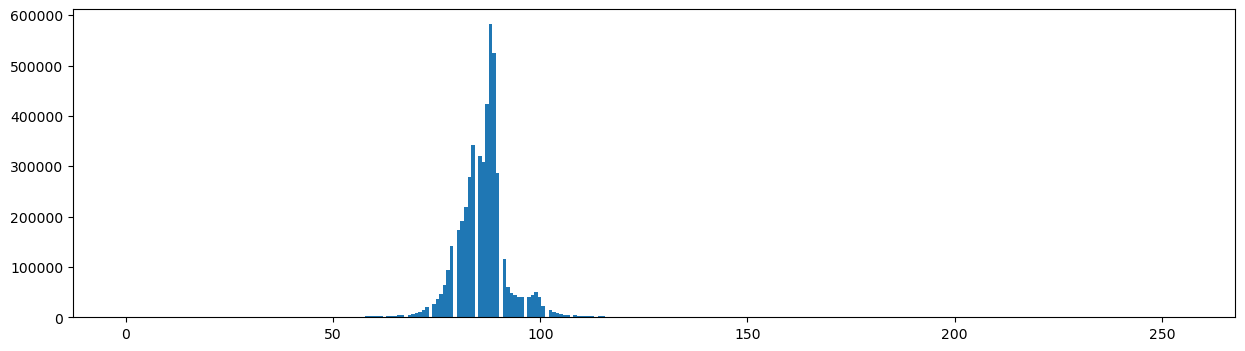

In [281]:
plt.figure(figsize=(15,4))
plt.hist(new_df.speed, bins = 300)
plt.show()

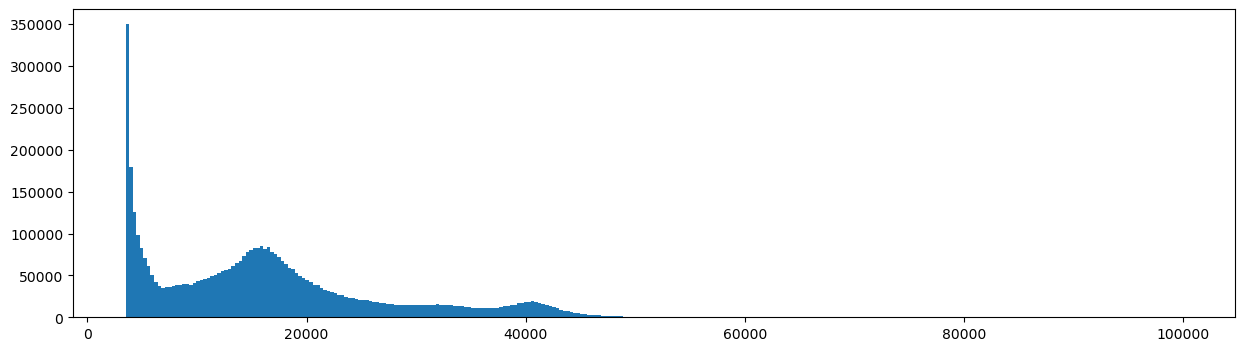

In [282]:
plt.figure(figsize=(15,4))
plt.hist(new_df.weight, bins = 300)
plt.show()

#### Check weight distribution accross types of vehicules

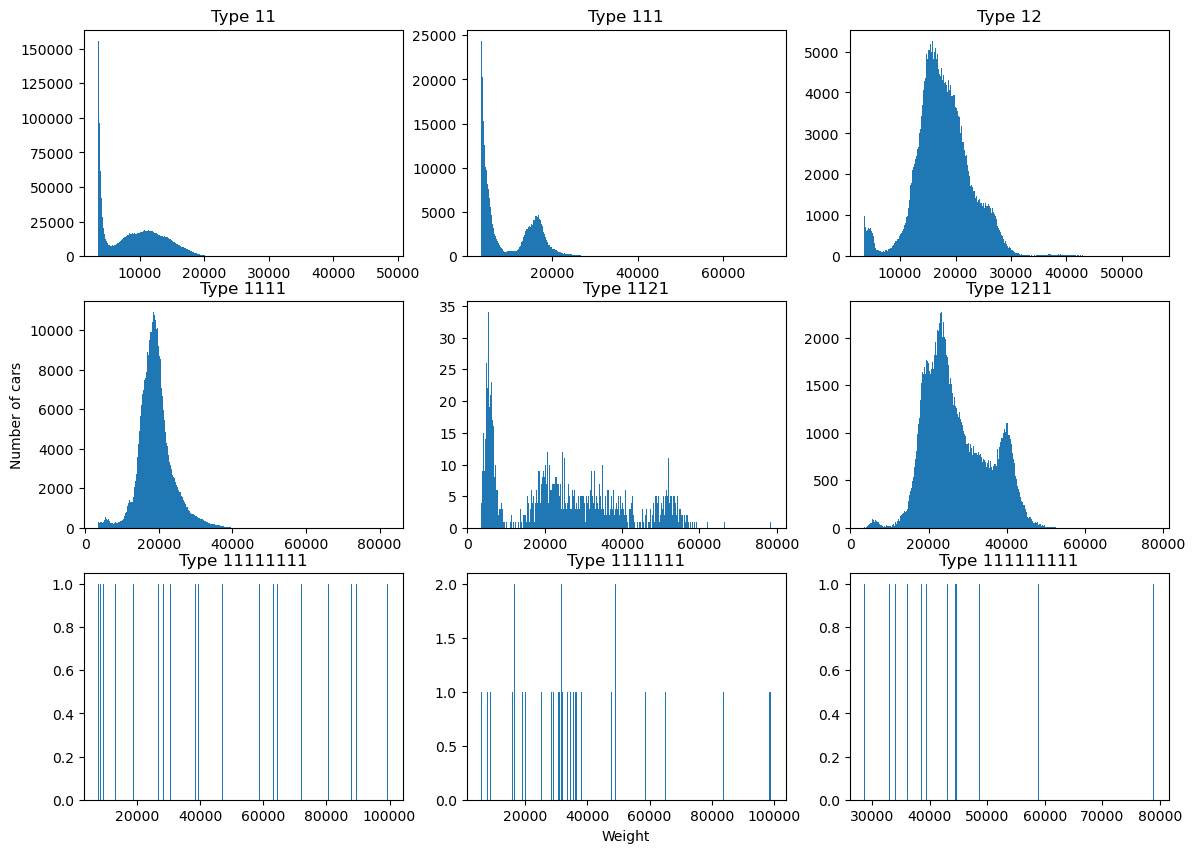

In [309]:
fig, axs = plt.subplots(3,3)
axs[0,0].hist(new_df.loc[new_df['type'] == 11].weight, bins = 300)
axs[0,0].set_title("Type 11")
axs[0,1].hist(new_df.loc[new_df['type'] == 111].weight, bins = 300)
axs[0,1].set_title("Type 111")
axs[0,2].hist(new_df.loc[new_df['type'] == 12].weight, bins = 300)
axs[0,2].set_title("Type 12")

axs[1,0].hist(new_df.loc[new_df['type'] == 1111].weight, bins = 300)
axs[1,0].set_title("Type 1111")
axs[1,0].set_ylabel("Number of cars")
axs[1,1].hist(new_df.loc[new_df['type'] == 1121].weight, bins = 300)
axs[1,1].set_title("Type 1121")
axs[1,2].hist(new_df.loc[new_df['type'] == 1211].weight, bins = 300)
axs[1,2].set_title("Type 1211")

axs[2,0].hist(new_df.loc[new_df['type'] == 11111111].weight, bins = 300)
axs[2,0].set_title("Type 11111111")
axs[2,1].hist(new_df.loc[new_df['type'] == 1111111].weight, bins = 300)
axs[2,1].set_title("Type 1111111")
axs[2,1].set_xlabel("Weight")
axs[2,2].hist(new_df.loc[new_df['type'] == 111111111].weight, bins = 300)
axs[2,2].set_title("Type 111111111")
plt.show()

#### Check speed distribution across types of vehicules

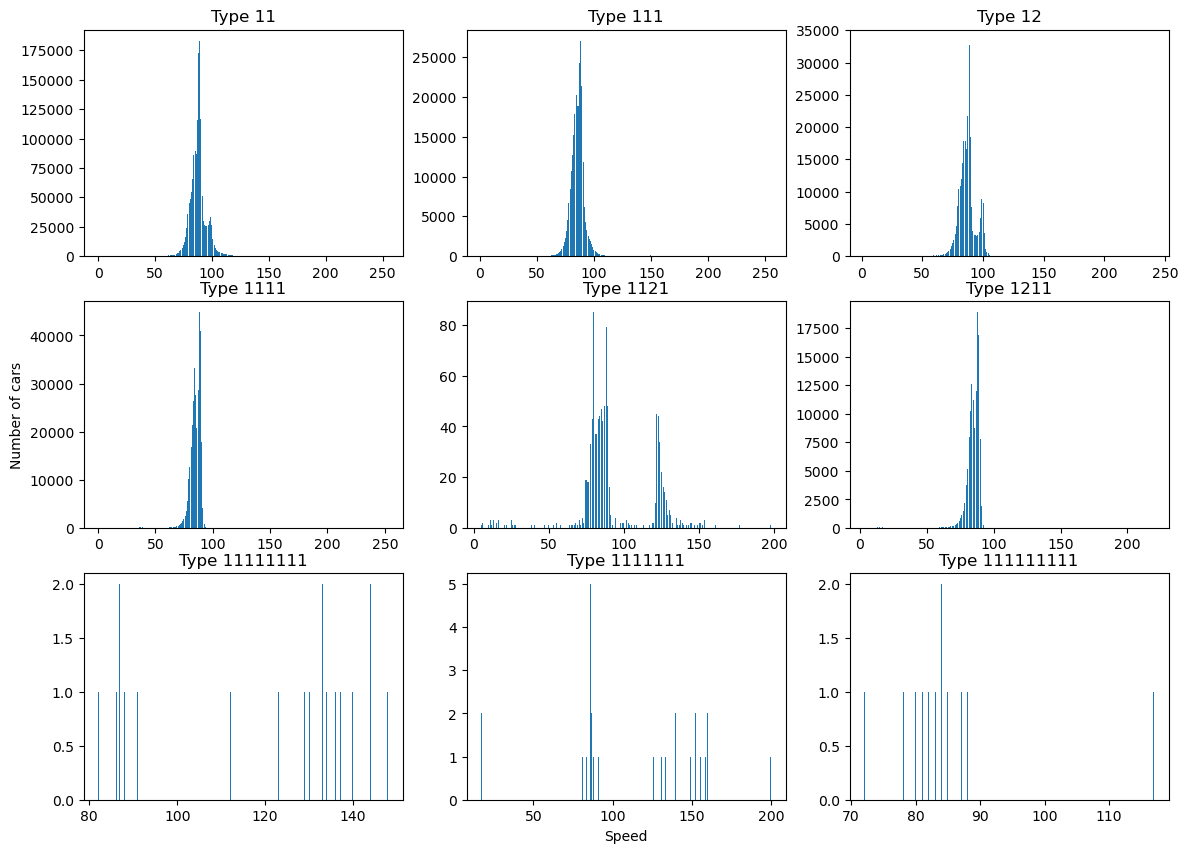

In [312]:
fig, axs = plt.subplots(3,3)
axs[0,0].hist(new_df.loc[new_df['type'] == 11].speed, bins = 300)
axs[0,0].set_title("Type 11")
axs[0,1].hist(new_df.loc[new_df['type'] == 111].speed, bins = 300)
axs[0,1].set_title("Type 111")
axs[0,2].hist(new_df.loc[new_df['type'] == 12].speed, bins = 300)
axs[0,2].set_title("Type 12")

axs[1,0].hist(new_df.loc[new_df['type'] == 1111].speed, bins = 300)
axs[1,0].set_title("Type 1111")
axs[1,0].set_ylabel("Number of cars")
axs[1,1].hist(new_df.loc[new_df['type'] == 1121].speed, bins = 300)
axs[1,1].set_title("Type 1121")
axs[1,2].hist(new_df.loc[new_df['type'] == 1211].speed, bins = 300)
axs[1,2].set_title("Type 1211")

axs[2,0].hist(new_df.loc[new_df['type'] == 11111111].speed, bins = 300)
axs[2,0].set_title("Type 11111111")
axs[2,1].hist(new_df.loc[new_df['type'] == 1111111].speed, bins = 300)
axs[2,1].set_title("Type 1111111")
axs[2,1].set_xlabel("Speed")
axs[2,2].hist(new_df.loc[new_df['type'] == 111111111].speed, bins = 300)
axs[2,2].set_title("Type 111111111")
plt.show()

In [325]:
new_df.loc[new_df['type'] == 11111].length.median()

1919.0

#### Check if there is indeed no cars exceeding 3.5t traveling Sunday 

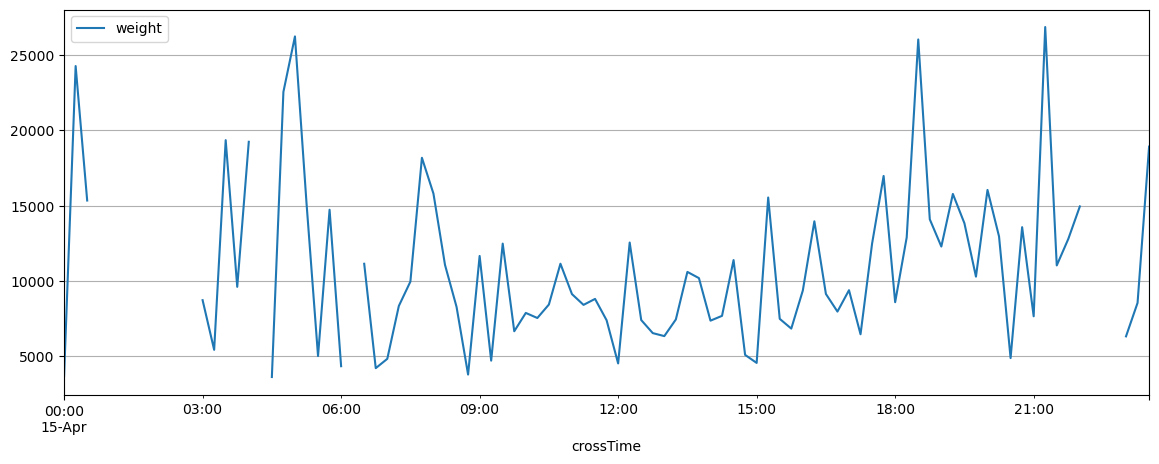

In [327]:
new_df_2018_4_15 = choose_date(new_df_2018_4, day = 15)
plot_features = new_df_2018_4_15.loc[:, ['weight']]

plot_features.index = new_df_2018_4_15['crossTime']
plot_features.resample('15T').mean().plot(subplots=True, grid=True, figsize=(14, 5))
plt.show()

## Autocorrelation and partial autocorrelation plot

In [88]:
#TODO

### Alerte chantier

In [20]:
dist_cols = [col for col in columns if col == 'speed']
new_distr = new_df[dist_cols]
new_distr.index = new_df.crossTime

In [21]:
new_distr.resample('2min').count().max()

speed    28
dtype: int64

N for each resampling
- Resample 1h : N = 396
- Resample 30min : N = 213
- Resample 15min : N = 117
- Resample 10 min : N = 93
- Resample 5min : N = 61
- Resample 3min : N = 39
- Resample 2min : N = 28
- Resample 1min : N = 21


In [24]:
blbl = new_distr.resample('2min').agg({'speed':[list, 'mean', 'std', 'count']})
#dfrs=df.resample('6H',on='date').agg({'x':[list,'mean']})


speed                 
                      list   mean std count
crossTime                                  
2011-04-01 00:40:00  [106]  106.0 NaN     1
2011-04-01 00:42:00  [116]  116.0 NaN     1
2011-04-01 00:44:00     []    NaN NaN     0
2011-04-01 00:46:00   [84]   84.0 NaN     1
2011-04-01 00:48:00     []    NaN NaN     0
...                    ...    ...  ..   ...
2021-03-28 23:20:00   [84]   84.0 NaN     1
2021-03-28 23:22:00   [82]   82.0 NaN     1
2021-03-28 23:24:00     []    NaN NaN     0
2021-03-28 23:26:00     []    NaN NaN     0
2021-03-28 23:28:00   [99]   99.0 NaN     1

[2627965 rows x 4 columns]

In [26]:
#plt.hist(blbl.iloc[0][0])
#plt.show()
blbl['speed']['count'].unique()

array([ 1,  0,  2,  3,  7,  4,  5,  6,  8,  9, 10, 11, 12, 14, 13, 19, 23,
       17, 15, 16, 21, 22, 18, 25, 20, 24, 26, 27, 28])

In [68]:
#blbl['speed']['list'].where(len(blbl['speed']['list']) > 27)
reblbl = blbl['speed']['count'].to_frame()

In [119]:
reblbl.loc[reblbl['count'] == 27]

,count
crossTime,
2017-12-05 07:32:00,27
2019-01-25 07:56:00,27
2019-01-29 07:44:00,27


In [95]:
#reblbl.iloc['2017-12-05 07:32:00']
reblbl.index.get_loc('2017-12-05 07:32:00')

1757006

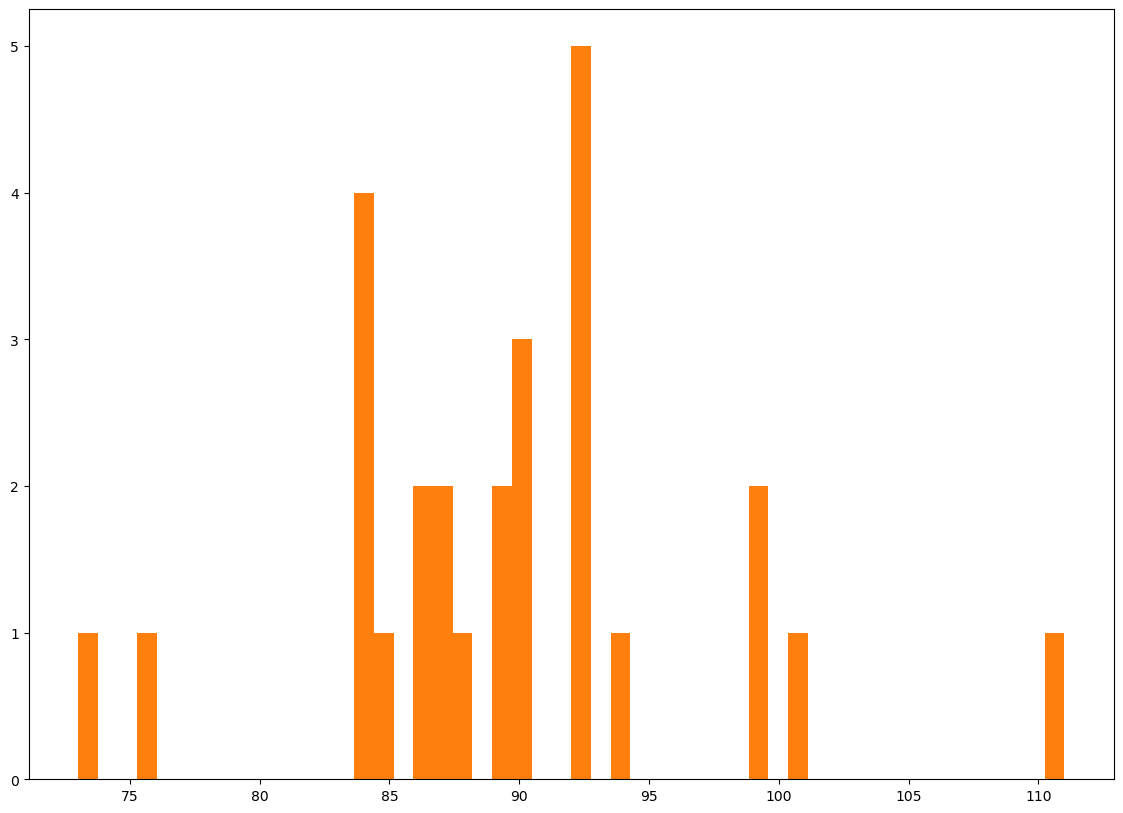

In [106]:
plt.hist(blbl['speed']['list'].iloc[1757006], bins=50)
plt.show()

In [45]:
#Trouve le timestep avec le + grand nbre de véhicules, retourne une liste
bite = max(blbl['speed']['list'], key=len)


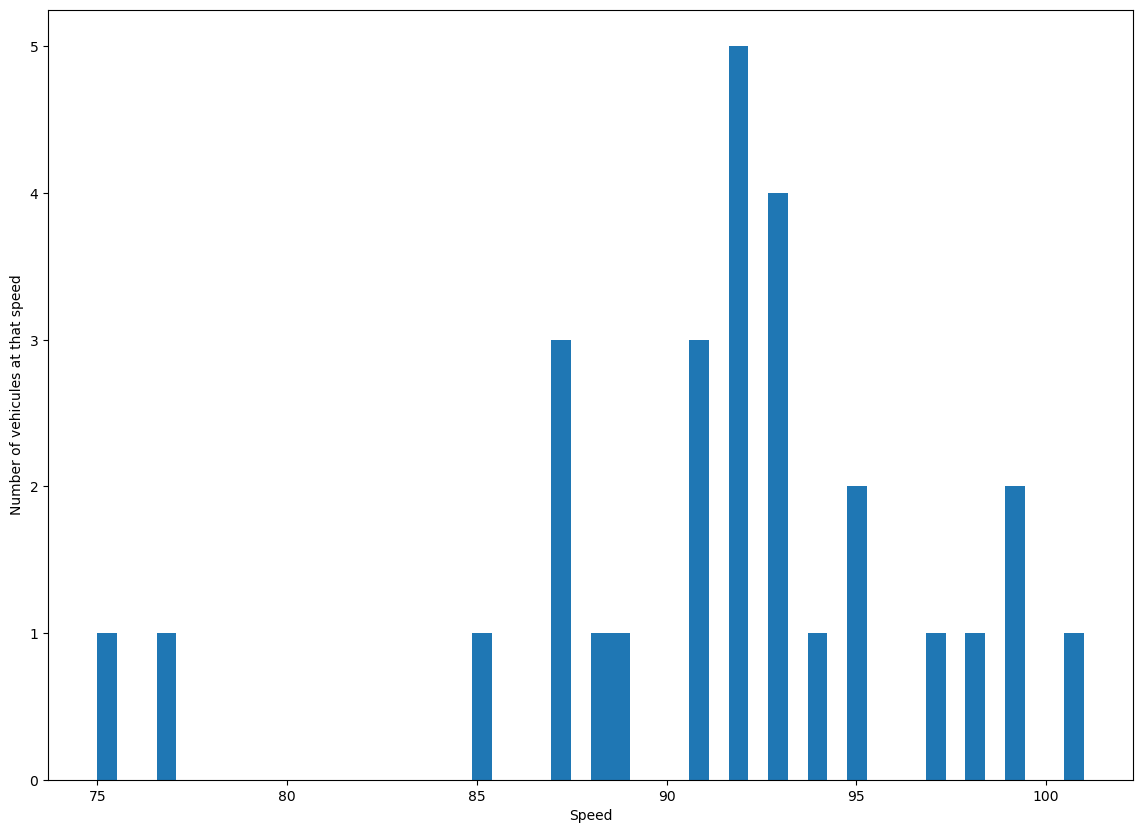

In [218]:
plt.hist(bite, bins=50)
plt.xlabel('Speed')
plt.ylabel('Number of vehicules at that speed')
plt.show()

### Define function that spreads vehicules over one hour (se base sur les données d'une semaine random pour l'instant


In [720]:
def dediscretize(uniques, counts, delay = 20):
    new_uniques = uniques.tolist()
    for count, unique in zip(counts, uniques):
        if count != 1:
            interval = delay / count
            time = 0
            for j in range(1, count):
                time = j*interval
                new_uniques.append(unique + time)
    return new_uniques

def passing_time(N, hour):
    new_df_2018_4 = choose_date(new_df, year = 2018, month = 4)
    new_df_2018_4_week = new_df_2018_4.loc[(new_df_2018_4['day'] >= 9) & (new_df_2018_4['day'] <= 15)]
    # On ajoute 9 car on part du 9 avril qui tombe sur un lundi
    day = hour // 24 + 9
    hour = hour % 24
    
    #on se base sur la semaine du 9 au 15 avril 2018 pour faire nos probas
    new_df_2018_4_week_hour = choose_date(new_df_2018_4_week, day = day, hour = hour)
    sampled_20s = new_df_2018_4_week_hour.resample('20s', on = 'crossTime').speed.agg(['count'])
    
    total = sampled_20s['count'].sum()
    sampled_20s['percentage'] = sampled_20s['count'] / total
    sampled_20s['cumsum'] = sampled_20s.percentage.cumsum()
    custm = scipy.stats.rv_discrete(a = 1, b = 0, values = ([*range(0, 3600, 20)], sampled_20s.percentage.to_list()))
    
    passing_times = custm.rvs(size = N)
    uniques, counts = np.unique(passing_times, return_counts=True)
    
    passing_times = dediscretize(uniques, counts)
    
    return passing_times

#### A priori it's ok mais je vais qd même checker si c'est des bons résultats, à faire après avoir mis en place la moyenne des semaines

In [721]:
passing_times = passing_time(174, 9)

In [ ]:
percentages = []
for time in list(set(passing_times)):
    percentages.append(passing_times.count(time) / len(passing_times))
percentages

In [603]:
unique, counts = np.unique(passing_times, return_counts=True)

In [515]:
percentages = [x/len(passing_times) for x in counts]

In [722]:
len(passing_times)


174

In [716]:
new_df_2018_4_week_hour = choose_date(new_df_2018_4_week, day = 9, hour = 9)

sampled_2min = new_df_2018_4_week_hour.resample('2T', on = 'crossTime').minute.agg(['count'])

total = sampled_2min['count'].sum()
sampled_2min['percentage'] = sampled_2min['count'] / total
sampled_2min['cumsum'] = sampled_2min.percentage.cumsum()

TODO LIST:
- Se baser sur plusieurs semaines au lieu d'une seule --> Moyenne
- Montrer statistiquement que ça répartit correctement les voitures
- Explorer length des vroums?

In [576]:
new_df_2018_4_week_hour = choose_date(new_df_2018_4_week, day = 9, hour = 9)
dist_cols = [col for col in columns if col == 'minute']
new_distr = new_df_2018_4_week_hour[dist_cols]
new_distr.index = new_df_2018_4_week_hour.crossTime
sampled_20s = new_distr.resample('20s').agg([list,'count']).minute



In [577]:
total = sampled_20s['count'].sum()
sampled_20s['percentage'] = sampled_20s['count'] / total
sampled_20s['cumsum'] = sampled_20s.percentage.cumsum()
#custm = scipy.stats.rv_discrete(a = 1, b = 0, values = ([*range(0, 3600, 15)], sampled_2min.percentage.to_list()))

In [581]:
# Nbre de secondes
3580 - (3580 // 60) * 60
# Nbre de minutes
3580 // 60

40

In [585]:
#sampled_20s
#print(len([*range(0, 3600, 20)]))
print(passing_times)
print(unique)
print(counts)

[ 260 1400 3040 3240 2640  480 1140 2940  620  260 2700 1560 1920 2640
  400 2960  920 1740 3400 2800 2580 2000 1000 2540 2420 2940 1920 2200
  620 1140 2120 1300  220 1320  260  920 2340 2900  240 3120 2560 1380
  920 1140 2700 1400 3580 3320   60 2560 1240  140 2420 2260  600 2540
 1140 2900 2120  960 1300  900  260 3240 1600 3160  720  240 2900 2800
 2340 3040 2200 2200  320  320 1280  400 1500 2560 2680 3160  800 1780
 1780 2940 2900 1640 1780  200  400 1500 2340 2480 1340 1220  120 1200
 2900 2480 2800  920 2800 2160 3240 2220 1640  740  620 1140 1480 1220
   20  680 2600 3160 2560  780 2620 2200 1280 1400 2700  480 2640 1680
 3360 3020 2720  900  720 1740 3320 2640  300  400 2480 2960 2580 1320
  900 2640  920 3220 2480 3040 1500  380 2900  460 2940 1320 1140 1660
 3160 2560 1500 2380 1140  780 3500 2940  480  920 2520 2040 1140 2700
 2340 3440  740 2960   60  720]
[  20   60  120  140  200  220  240  260  300  320  380  400  460  480
  600  620  680  720  740  780  800  900  920

In [913]:
#passer une copie de df et non df lui-même
def define_usual_week(df, year = 2018):
    probas_df = pd.DataFrame()
    new_df = choose_date(df, year = year).copy()
    new_df['week'] = new_df['crossTime'].dt.week
    max_week = new_df['week'].max()
    weeks = new_df.groupby('week')
    for i in range(2, max_week):
        week = weeks.get_group(i)
        day_dates = week['day'].unique()
        days = week.groupby('day')
        week_probas = []
        for day_date in day_dates:
            day = days.get_group(day_date)
            ################ Y a des heures qui n'existent pas psk aucune voiture est passée dans l'heure
            list_hours = day['hour'].unique()
            full_list = np.array([*range(0,24)])
            if not np.array_equal(list_hours, full_list):
                missing_hours = list(set(full_list) - set(list_hours))
            ##########
            date_issue = '2018-02-25 05:00:00'
            date_issue = pd.to_datetime(date_issue)
            mod_new_df_issue = new_df_issue.append({'crossTime': date_issue,
                                              'hour' : 5}, ignore_index = True)
            mod_new_df_issue = mod_new_df_issue.fillna(0)
            sorted_mod_new_def_issue = mod_new_df_issue.sort_values(by = 'crossTime')
            test_sampled = choose_date(sorted_mod_new_def_issue, hour = 5)
            test_sampled = test_sampled.resample('20s', on = 'crossTime').speed.agg(['count'])
            test_sampled.iloc[0] = 0
            test_sampled
            ##########
            
            ################ Y a des heures qui n'existent pas psk aucune voiture est passée dans l'heure
            hours = day.groupby('hour')
            for j in range(0,24):
                hour = hours.get_group(j)
                month = hour['month'].iloc[0]
                sampled_20s = hour.resample('20s', on = 'crossTime').speed.agg(['count'])
                #create full hour to fill up the holes in sampled_20s
                start = f'{year}-{month}-{day_date} {j}:00:00'
                end = f'{year}-{month}-{day_date} {j}:59:40'
                dummy_hour = pd.date_range(start = start, end = end, freq = '20s').to_frame()
                sampled_20s = dummy_hour.merge(sampled_20s, how = 'outer', left_on = 0, right_on = 'crossTime')
                sampled_20s['count'] = sampled_20s['count'].fillna(0)
                #create cumulative sum of probabilities
                total = sampled_20s['count'].sum()
                sampled_20s['percentage'] = sampled_20s['count'] / total
                sampled_20s['cumsum'] = sampled_20s.percentage.cumsum()
                probas = sampled_20s['cumsum'].tolist()
                week_probas.append([probas])
        #Creates dataframe of probabilities, columns are week numbers and rows are hour numbers
        probas_df[f'{i}'] = pd.DataFrame(week_probas, columns = [f'{i}'])
    #Transpose the probas_df to aggregate on columns hour
    probas_df = probas_df.T
    columns = list(probas_df)
    #to order the hours by their number in the week : 0 to 7*24 - 1
    hour_of_week = 0
    for col in columns:
        hour = probas_df[col].tolist()
        arrays = [np.array(x) for x in hour]
        mean_probas_hour = [np.mean(k) for k in zip(*arrays)]
        mean_probas_week[f'{hour_of_week}'] = pd.DataFrame(mean_probas_hour, columns = [f'{hour_of_week}'])
        hour_of_week += 1
    #mean_probas_week should be a dataframe of mean of cumulative sums of probabilites of hours of every week
    #columns are hour id in the week, rows are probabilities that there is a vehicule on intervals of 20 secondes
    return mean_probas_week

In [914]:
gros_test = define_usual_week(new_df)

jour : 8, semaine : 2
jour : 9, semaine : 2
jour : 10, semaine : 2
jour : 11, semaine : 2
jour : 12, semaine : 2
jour : 13, semaine : 2
jour : 14, semaine : 2
jour : 15, semaine : 3
jour : 16, semaine : 3
jour : 17, semaine : 3
jour : 18, semaine : 3
jour : 19, semaine : 3
jour : 20, semaine : 3
jour : 21, semaine : 3
jour : 22, semaine : 4
jour : 23, semaine : 4
jour : 24, semaine : 4
jour : 25, semaine : 4
jour : 26, semaine : 4
jour : 27, semaine : 4
jour : 28, semaine : 4
jour : 29, semaine : 5
jour : 30, semaine : 5
jour : 31, semaine : 5
jour : 1, semaine : 5
jour : 2, semaine : 5
jour : 3, semaine : 5
jour : 4, semaine : 5
jour : 5, semaine : 6
jour : 6, semaine : 6
jour : 7, semaine : 6
jour : 8, semaine : 6
jour : 9, semaine : 6
jour : 10, semaine : 6
jour : 11, semaine : 6
jour : 12, semaine : 7
jour : 13, semaine : 7
jour : 14, semaine : 7
jour : 15, semaine : 7
jour : 16, semaine : 7
jour : 17, semaine : 7
jour : 18, semaine : 7
jour : 19, semaine : 8
jour : 20, semaine : 8

KeyError: 5

In [644]:
jour = define_usual_week(new_df, 2019)

In [928]:
new_df_issue = choose_date(new_df, year = 2018, month = 2, day = 25)
new_df_issue['hour'].unique()
#Il manque 5h du mat

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])

In [952]:
list_hours = new_df_issue['hour'].unique()
full_list = np.array([*range(0,24)])
print(list_hours)
print(full_list)
if not np.array_equal(list_hours, full_list):
    main_list = list(set(full_list) - set(list_hours))
main_list

[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


[5]

In [930]:
date_issue = '2018-02-25 05:00:00'
date_issue = pd.to_datetime(date_issue)
mod_new_df_issue = new_df_issue.append({'crossTime': date_issue,
                                  'hour' : 5}, ignore_index = True)
mod_new_df_issue = mod_new_df_issue.fillna(0)
sorted_mod_new_def_issue = mod_new_df_issue.sort_values(by = 'crossTime')
test_sampled = choose_date(sorted_mod_new_def_issue, hour = 5)
test_sampled = test_sampled.resample('20s', on = 'crossTime').speed.agg(['count'])
test_sampled.iloc[0] = 0
test_sampled

In [938]:
mod_new_df_issue = mod_new_df_issue.fillna(0)

In [940]:
sorted_mod_new_def_issue = mod_new_df_issue.sort_values(by = 'crossTime')

In [947]:
test_sampled = choose_date(sorted_mod_new_def_issue, hour = 5)
test_sampled = test_sampled.resample('20s', on = 'crossTime').speed.agg(['count'])
test_sampled.iloc[0] = 0
test_sampled

,count
crossTime,
2018-02-25 05:00:00,0


In [803]:
new_df_2018 = choose_date(new_df, year = 2018).copy()
new_df_2018['week'] = new_df_2018['crossTime'].dt.week

In [819]:
week = new_df_2018.groupby('week').get_group(2)

In [821]:
day = week.groupby('day').get_group(9)

In [824]:
hour = day.groupby('hour').get_group(5)

In [883]:
hour['month'].iloc[0]

1

In [828]:
hour_resampled = hour.resample('20s', on = 'crossTime').speed.agg(['count'])


In [830]:
hour_resampled['count'].sum()

37

In [888]:
dummy_hour = pd.date_range(start = '2018-1-9 5:00:00', end = '2018-01-09 05:59:40', freq = '20s').to_frame()

In [891]:
bite = 0
print(f'il y a {bite} bite.')

il y a 0 bite.


In [856]:
full_hour = dummy_hour.merge(hour_resampled, how = 'outer', left_on = 0, right_on = 'crossTime')

In [857]:
full_hour['count'] = full_hour['count'].fillna(0)

In [859]:
full_hour = full_hour.rename(columns={0:'crossTime'})


In [860]:
full_hour

,crossTime,count
0,2018-01-09 05:00:00,0.0
1,2018-01-09 05:00:20,0.0
2,2018-01-09 05:00:40,0.0
3,2018-01-09 05:01:00,0.0
4,2018-01-09 05:01:20,0.0
...,...,...
175,2018-01-09 05:58:20,0.0
176,2018-01-09 05:58:40,0.0
177,2018-01-09 05:59:00,0.0
178,2018-01-09 05:59:20,0.0


In [812]:
blop = choose_date(blop, day = 8, hour = 0)

In [814]:
blip = blop.resample('20s', on = 'crossTime').minute.agg(['count'])

In [897]:
test = [[[1, 2]], [[5, 4]]]
test_df = pd.DataFrame(test, columns = ['a'])
test_df['b'] = pd.DataFrame(test, columns = ['b'])

In [898]:
test_df['a']

,a,b
0,"[1, 2]","[1, 2]"
1,"[5, 4]","[5, 4]"


In [875]:
bip = test_df['a'].tolist()

In [877]:
bip.append([3, 6])

In [880]:
bip

[[1, 2], [5, 4], [3, 6]]

In [901]:
fuck = [[[1,2]]]
fuck.append([[3,4]])

In [903]:
test_df['c'] = pd.DataFrame(fuck ,columns = ['c'])

In [904]:
test_df

,a,b,c
0,"[1, 2]","[1, 2]","[1, 2]"
1,"[5, 4]","[5, 4]","[3, 4]"


In [879]:
bip = test_df['a'].tolist()
arrays = [np.array(x) for x in bip]
[np.mean(k) for k in zip(*arrays)]


[3.0, 4.0]

In [784]:
#new_df_2018.loc[new_df_2018['day'] == 8]
hour = 4
whole_week = pd.date_range(start = f'2018-01-01 {hour}:00:00', end = '2018-02-01 01:00:00', freq = '20s').to_frame()

In [785]:
whole_week

,0
2018-01-01 00:00:00,2018-01-01 00:00:00
2018-01-01 00:00:20,2018-01-01 00:00:20
2018-01-01 00:00:40,2018-01-01 00:00:40
2018-01-01 00:01:00,2018-01-01 00:01:00
2018-01-01 00:01:20,2018-01-01 00:01:20
...,...
2018-02-01 00:58:40,2018-02-01 00:58:40
2018-02-01 00:59:00,2018-02-01 00:59:00
2018-02-01 00:59:20,2018-02-01 00:59:20
2018-02-01 00:59:40,2018-02-01 00:59:40


In [788]:
 = pd.merge(blop, whole_week, left_on='crossTime', right_on=0,
    how='right').sort_values(by = 'crossTime', ascending = True)

In [793]:
blip['count'].unique()

array([nan,  1.,  0.])

In [777]:
new_df_2018_4_week_hour = choose_date(new_df_2018_4_week, day = 9, hour = 9)
sampled_20s = new_df_2018_4_week_hour.resample('20s', on = 'crossTime').speed.agg(['count'])

total = sampled_20s['count'].sum()
sampled_20s['percentage'] = sampled_20s['count'] / total
sampled_20s['cumsum'] = sampled_20s.percentage.cumsum()

In [818]:
new_df.day.iloc[0]

1

- Faire moyennes des probas de l'heure 0 de chaque semaine de l'année
- Puis same pour heure 1, .., 7*24